In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Import Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image
%matplotlib inline
from skimage import img_as_ubyte
from skimage import restoration, img_as_ubyte
from skimage.feature import canny
from skimage.morphology import binary_dilation, binary_erosion
from skimage.morphology import skeletonize

#Convex Hull + No. of Leaves Count

In [27]:
# Load your image (replace 'path/to/your/image.jpg' with the actual path)
image_path = '/content/drive/MyDrive/Background_removed_lettuce/background_removed_lettuce/01/plant1_01_06_2023_15_balcony.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

In [28]:
# Step 1: Image Enhancement using Deconvolution
psf = np.ones((5, 5)) / 25  # Example point spread function
deconvolved = cv2.filter2D(image, -1, psf)

In [29]:
# Step 2: Bounding Box
contours, _ = cv2.findContours(img_as_ubyte(deconvolved), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
x, y, w, h = cv2.boundingRect(contours[0])

In [6]:
# Step 3: Centroid Computation of Bounding Box
centroid_x = x + w // 2
centroid_y = y + h // 2

In [24]:
print(centroid_x, centroid_y)

337 272


In [25]:
image.shape


(545, 675)

In [7]:
# Step 4: Circle at the center of bounding box and exclude that region
radius = 50  # Adjust the radius as needed
mask = np.zeros_like(deconvolved)
cv2.circle(mask, (centroid_x, centroid_y), radius, 255, -1)
deconvolved[mask == 255] = 0

In [8]:
# Step 5: Canny Edge Detection
edge_canny = canny(deconvolved, sigma=2)

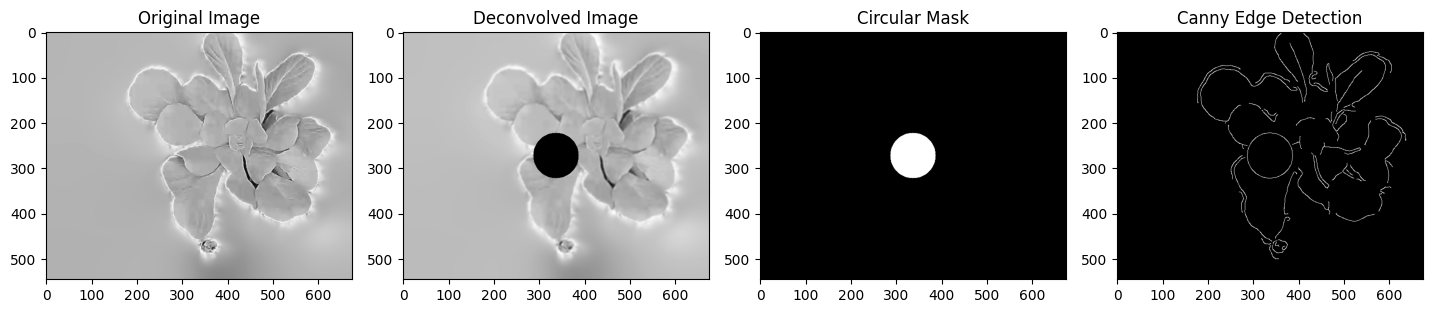

In [9]:
# Visualize the results
plt.figure(figsize=(18, 5))

plt.subplot(1, 5, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 5, 2)
plt.imshow(deconvolved, cmap='gray')
plt.title('Deconvolved Image')

plt.subplot(1, 5, 3)
plt.imshow(mask, cmap='gray')
plt.title('Circular Mask')

plt.subplot(1, 5, 4)
plt.imshow(edge_canny, cmap='gray')
plt.title('Canny Edge Detection')

plt.tight_layout()
plt.show()

As it is evident from the above images that the circular mask is not at the center thereby it requires further refinement

In [10]:
# Step 6: Thresholding
_, binary_image = cv2.threshold(deconvolved, 200, 255, cv2.THRESH_BINARY)


In [11]:
# Step 7: Morphological Operations (Erosion and Dilation)
kernel = np.ones((5, 5), np.uint8)
morph_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

In [12]:
# Step 8: Contour Detection
contours, _ = cv2.findContours(morph_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


In [13]:
# Step 9: Filtering Contours based on Size
filtered_contours = [cnt for cnt in contours if 100 < cv2.contourArea(cnt) < 5000]

In [14]:
# Step 10: Convex Hull
convex_hulls = [cv2.convexHull(cnt) for cnt in filtered_contours]


In [15]:
# Step 11: Leaf Feature Extraction
leaf_features = [{'area': cv2.contourArea(cnt), 'perimeter': cv2.arcLength(cnt, True)} for cnt in convex_hulls]

In [16]:
# Step 12: Leaf Labeling
labels = np.zeros_like(binary_image)
for i, cnt in enumerate(convex_hulls):
    cv2.drawContours(labels, [cnt], -1, i + 1, thickness=cv2.FILLED)

In [17]:
# Step 13: Counting Leaves
num_leaves = len(leaf_features)
print(num_leaves)

14


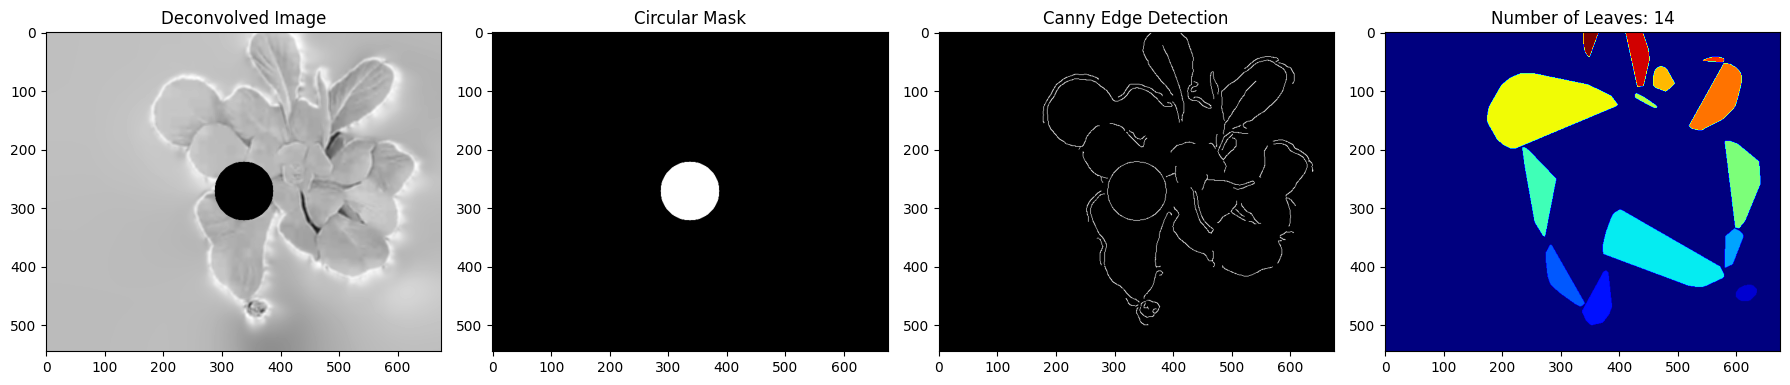

In [19]:
# Visualize the results
plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
plt.imshow(deconvolved, cmap='gray')
plt.title('Deconvolved Image')

plt.subplot(1, 4, 2)
plt.imshow(mask, cmap='gray')
plt.title('Circular Mask')

plt.subplot(1, 4, 3)
plt.imshow(edge_canny, cmap='gray')
plt.title('Canny Edge Detection')

plt.subplot(1, 4, 4)
plt.imshow(labels, cmap='jet')
plt.title(f'Number of Leaves: {num_leaves}')

plt.tight_layout()
plt.show()

Above results are obtained using Convex hull

#Refined Approach for Centroid Computation of Bounding box

As earlier, circular mask was not in the center of plant and it required further refinement. Below is the correct way of obtaining the center location

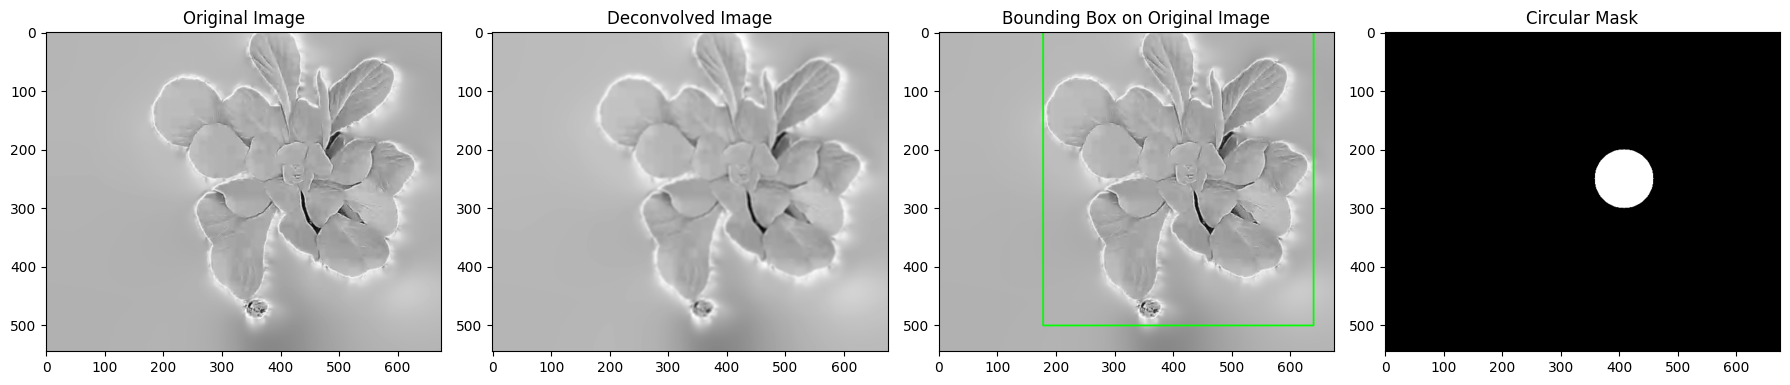

In [31]:
# Step 1: Image Enhancement using Deconvolution
psf = np.ones((5, 5)) / 25  # Example point spread function
deconvolved = cv2.filter2D(image, -1, psf)

# Step 2: Canny Edge Detection
edge_canny = canny(deconvolved, sigma=2)

# Step 3: Find contours in the Canny edge image
contours, _ = cv2.findContours(img_as_ubyte(edge_canny), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 4: Initialize variables for bounding box
min_x, min_y, max_x, max_y = float('inf'), float('inf'), 0, 0

# Step 5: Iterate through contours to find bounding box coordinates
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    min_x = min(min_x, x)
    min_y = min(min_y, y)
    max_x = max(max_x, x + w)
    max_y = max(max_y, y + h)

# Step 6: Visualize the bounding box on the original image
image_with_bounding_box = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)
cv2.rectangle(image_with_bounding_box, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)

# Step 7: Calculate the center of the bounding box
plant_center_x = (min_x + max_x) // 2
plant_center_y = (min_y + max_y) // 2

# Step 8: Create a circular mask around the plant
radius = 50  # Adjust the radius as needed
mask = np.zeros_like(image)
cv2.circle(mask, (plant_center_x, plant_center_y), radius, 255, -1)

# Visualize the results
plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(deconvolved, cmap='gray')
plt.title('Deconvolved Image')

plt.subplot(1, 4, 3)
plt.imshow(image_with_bounding_box)
plt.title('Bounding Box on Original Image')

plt.subplot(1, 4, 4)
plt.imshow(mask, cmap='gray')
plt.title('Circular Mask')

plt.tight_layout()
plt.show()

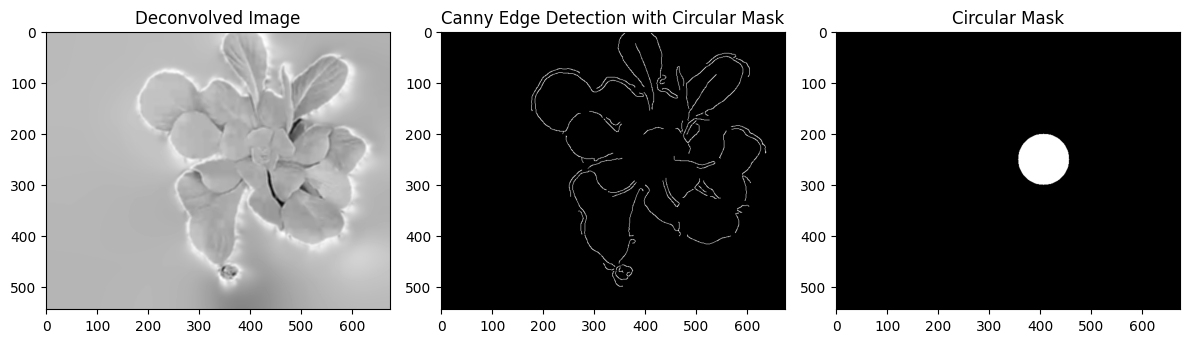

In [19]:
# Step 8: Set the circular region in the Canny image to zero
edge_canny[mask == 255] = 0

# Visualize the results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(deconvolved, cmap='gray')
plt.title('Deconvolved Image')

plt.subplot(1, 3, 2)
plt.imshow(edge_canny, cmap='gray')
plt.title('Canny Edge Detection with Circular Mask')

plt.subplot(1, 3, 3)
plt.imshow(mask, cmap='gray')
plt.title('Circular Mask')

plt.tight_layout()
plt.show()

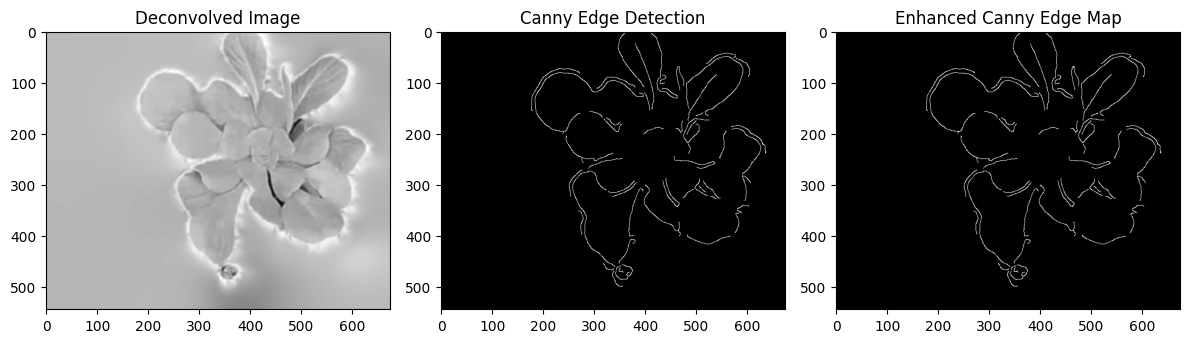

In [20]:
# Step 3: Apply morphological dilation to connect broken edges
edge_canny_dilated = binary_dilation(edge_canny)

# Step 4: Apply morphological erosion to refine edges
edge_canny_enhanced = binary_erosion(edge_canny_dilated)

# Visualize the results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(deconvolved, cmap='gray')
plt.title('Deconvolved Image')

plt.subplot(1, 3, 2)
plt.imshow(edge_canny, cmap='gray')
plt.title('Canny Edge Detection')

plt.subplot(1, 3, 3)
plt.imshow(edge_canny_enhanced, cmap='gray')
plt.title('Enhanced Canny Edge Map')

plt.tight_layout()
plt.show()

#Sharpening Canny Edge Image using Morphological Operations

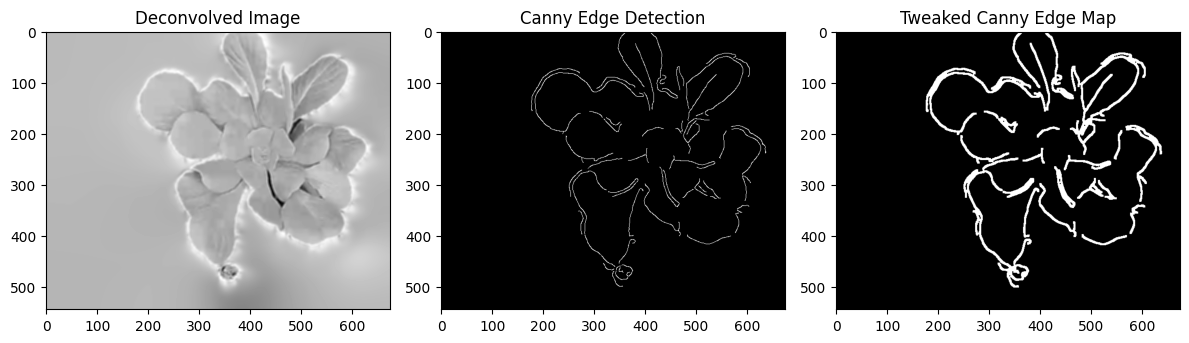

In [8]:
# Step 2: Canny Edge Detection with increased sigma
edge_canny = canny(deconvolved, sigma=2)

# Step 3: Manually tweak edges using morphological operations
kernel_dilate = np.ones((5, 5), np.uint8)
kernel_erode = np.ones((2, 2), np.uint8)

edge_canny_dilated = cv2.dilate(img_as_ubyte(edge_canny), kernel_dilate, iterations=1)
edge_canny_tweaked = cv2.erode(edge_canny_dilated, kernel_erode, iterations=1)

# Visualize the results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(deconvolved, cmap='gray')
plt.title('Deconvolved Image')

plt.subplot(1, 3, 2)
plt.imshow(edge_canny, cmap='gray')
plt.title('Canny Edge Detection')

plt.subplot(1, 3, 3)
plt.imshow(edge_canny_tweaked, cmap='gray')
plt.title('Tweaked Canny Edge Map')

plt.tight_layout()
plt.show()

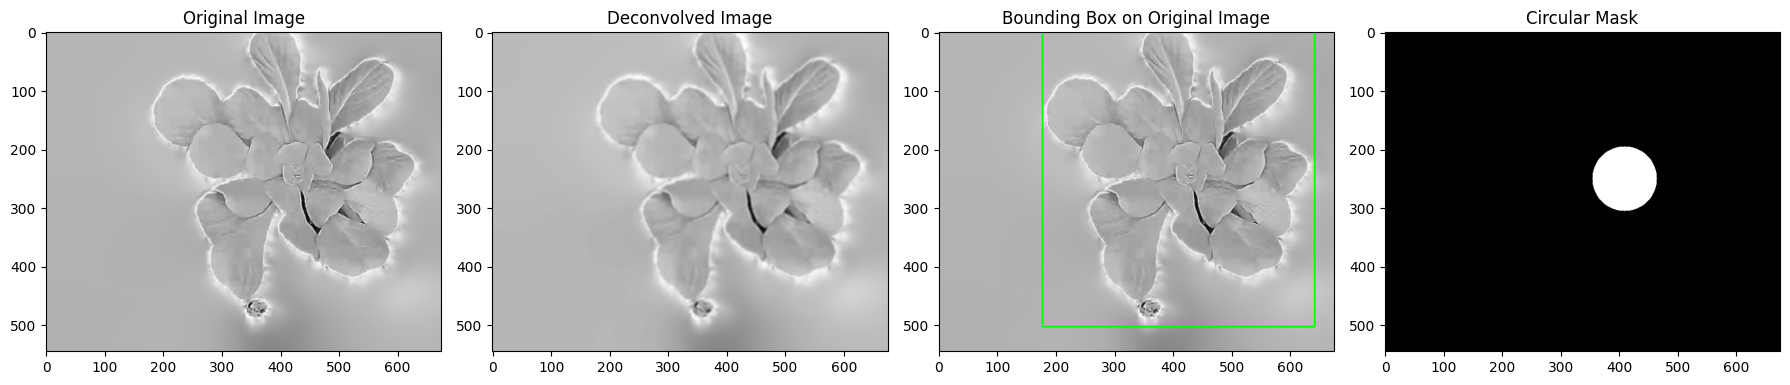

In [9]:
# Step 2: Canny Edge Detection with increased sigma
edge_canny = canny(deconvolved, sigma=2)

# Step 3: Manually tweak edges using morphological operations
kernel_dilate = np.ones((5, 5), np.uint8)
kernel_erode = np.ones((2, 2), np.uint8)

edge_canny_dilated = cv2.dilate(img_as_ubyte(edge_canny), kernel_dilate, iterations=1)
edge_canny_tweaked = cv2.erode(edge_canny_dilated, kernel_erode, iterations=1)

# Step 3: Find contours in the Canny edge image
contours, _ = cv2.findContours(img_as_ubyte(edge_canny_tweaked), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 4: Initialize variables for bounding box
min_x, min_y, max_x, max_y = float('inf'), float('inf'), 0, 0

# Step 5: Iterate through contours to find bounding box coordinates
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    min_x = min(min_x, x)
    min_y = min(min_y, y)
    max_x = max(max_x, x + w)
    max_y = max(max_y, y + h)

# Step 6: Visualize the bounding box on the original image
image_with_bounding_box = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)
cv2.rectangle(image_with_bounding_box, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)

# Step 7: Calculate the center of the bounding box
plant_center_x = (min_x + max_x) // 2
plant_center_y = (min_y + max_y) // 2

# Step 8: Create a circular mask around the plant
radius = 55  # Adjust the radius as needed
mask = np.zeros_like(image)
cv2.circle(mask, (plant_center_x, plant_center_y), radius, 255, -1)

# Step 10: Overlay the circular mask on the Canny edge image
edge_canny_tweaked[mask == 255] = 0

# Visualize the results
plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(deconvolved, cmap='gray')
plt.title('Deconvolved Image')

plt.subplot(1, 4, 3)
plt.imshow(image_with_bounding_box)
plt.title('Bounding Box on Original Image')

plt.subplot(1, 4, 4)
plt.imshow(mask, cmap='gray')
plt.title('Circular Mask')

plt.tight_layout()
plt.show()

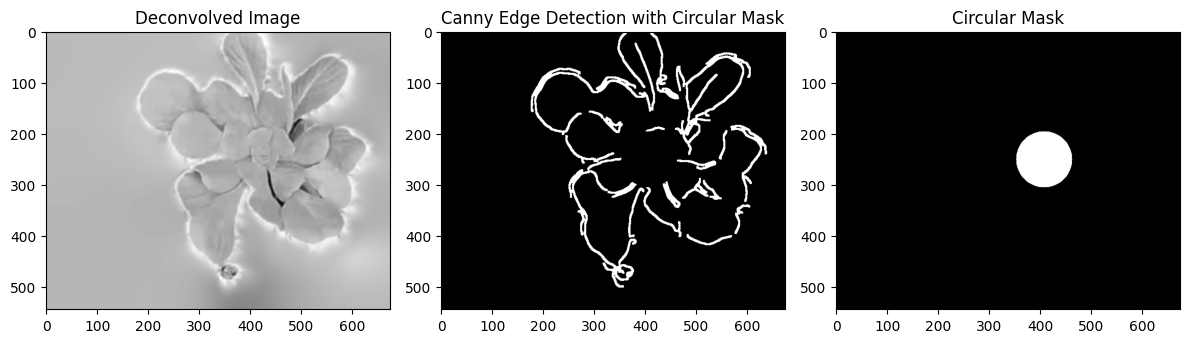

In [52]:
# Step 8: Set the circular region in the Canny image to zero
edge_canny_tweaked[mask == 255] = 0

# Visualize the results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(deconvolved, cmap='gray')
plt.title('Deconvolved Image')

plt.subplot(1, 3, 2)
plt.imshow(edge_canny_tweaked, cmap='gray')
plt.title('Canny Edge Detection with Circular Mask')

plt.subplot(1, 3, 3)
plt.imshow(mask, cmap='gray')
plt.title('Circular Mask')

plt.tight_layout()
plt.show()

#Canny Edge Detection + Center Computation + Circle Formation

In previous analysis as the circle was drwan at the center part of plant and leaves present there were excluded. So this time I decided to visualise the circle at center.

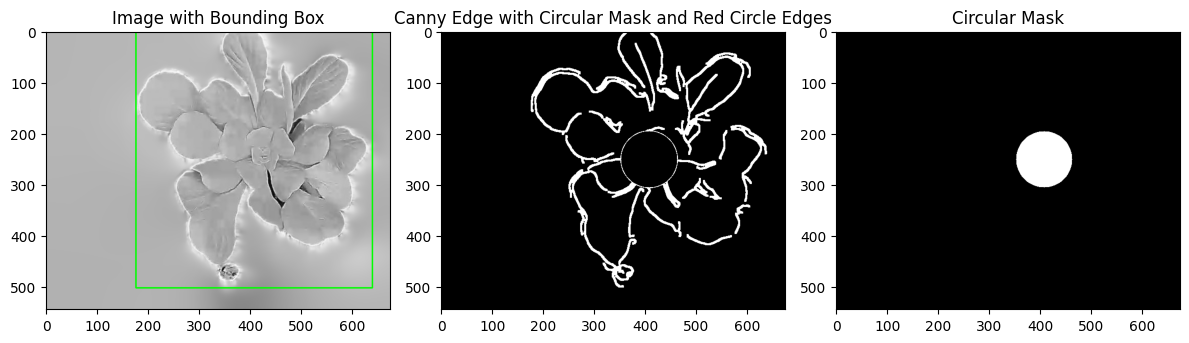

In [35]:
# Step 2: Canny Edge Detection with increased sigma
edge_canny = canny(deconvolved, sigma=2)

# Step 3: Manually tweak edges using morphological operations
kernel_dilate = np.ones((5, 5), np.uint8)
kernel_erode = np.ones((2, 2), np.uint8)

edge_canny_dilated = cv2.dilate(img_as_ubyte(edge_canny), kernel_dilate, iterations=1)
edge_canny_tweaked = cv2.erode(edge_canny_dilated, kernel_erode, iterations=1)

# Step 4: Find contours in the Canny edge image
contours, _ = cv2.findContours(img_as_ubyte(edge_canny_tweaked), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 5: Initialize variables for bounding box
min_x, min_y, max_x, max_y = float('inf'), float('inf'), 0, 0

# Step 6: Iterate through contours to find bounding box coordinates
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    min_x = min(min_x, x)
    min_y = min(min_y, y)
    max_x = max(max_x, x + w)
    max_y = max(max_y, y + h)

# Step 7: Visualize the bounding box on the original image
image_with_bounding_box = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)
cv2.rectangle(image_with_bounding_box, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)

# Step 8: Calculate the center of the bounding box
plant_center_x = (min_x + max_x) // 2
plant_center_y = (min_y + max_y) // 2

# Step 9: Create a circular mask around the plant
radius = 55  # Adjust the radius as needed
mask = np.zeros_like(image)
cv2.circle(mask, (plant_center_x, plant_center_y), radius, 255, -1)

# Step 10: Overlay the circular mask on the Canny edge image with circle edges in red
edge_canny_tweaked_with_circle = edge_canny_tweaked.copy()
cv2.circle(edge_canny_tweaked_with_circle, (plant_center_x, plant_center_y), radius, (255, 0, 0), 2)

# Step 11: Ignore edges inside the circular mask
edge_canny_tweaked_with_circle[mask == 255] = 0

# Step 12: Visualize the result
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image_with_bounding_box, cmap='gray')
plt.title('Image with Bounding Box')

plt.subplot(1, 3, 2)
plt.imshow(edge_canny_tweaked_with_circle, cmap='gray')
plt.title('Canny Edge with Circular Mask and Red Circle Edges')

plt.subplot(1, 3, 3)
plt.imshow(mask, cmap='gray')
plt.title('Circular Mask')

plt.tight_layout()
plt.show()

# Shape Descriptors

Here, idea is to extract the leave's shapes. Hu moment and Fourier Desciptors are used here

In [36]:
# Calculate Hu Moments for each contour
hu_moments_list = []
for contour in contours:
    moments = cv2.moments(contour)
    hu_moments = cv2.HuMoments(moments).flatten()
    hu_moments_list.append(hu_moments)

# Calculate Fourier Descriptors for each contour
fourier_descriptors_list = []
for contour in contours:
    # Perform Fourier Transform
    fourier_transform = np.fft.fft(contour[:, 0, 0] + 1j * contour[:, 0, 1])

    # Keep the first few coefficients (you may adjust the number)
    num_coefficients = 10
    fourier_descriptors = np.abs(fourier_transform[:num_coefficients])
    fourier_descriptors_list.append(fourier_descriptors)

# Visualize results
for i in range(len(contours)):
    print(f"Contour {i + 1} - Hu Moments: {hu_moments_list[i]}, Fourier Descriptors: {fourier_descriptors_list[i]}")

Contour 1 - Hu Moments: [ 1.87078045  2.9800702   1.30614999  0.14918562 -0.06126719 -0.24435791
  0.02414906], Fourier Descriptors: [7.83725024e+04 2.05038757e+03 2.62506583e+02 9.26289295e+01
 9.83873581e+01 1.68504662e+02 1.07576584e+01 3.04518020e+01
 1.69520861e+01 4.24499022e+01]
Contour 2 - Hu Moments: [0.91730984 0.60597055 0.35022813 0.114191   0.0194937  0.06267709
 0.01189481], Fourier Descriptors: [6.34313788e+04 1.06099733e+03 2.56016225e+02 9.70756980e+01
 5.98658130e+01 1.17212542e+02 7.12436650e+01 2.51522496e+01
 6.11886304e+01 3.81650450e+01]
Contour 3 - Hu Moments: [ 2.37331862  5.2948128   0.85717073  0.17732228  0.02769077 -0.0213783
  0.06334385], Fourier Descriptors: [5.38373902e+04 1.98694736e+03 5.00083469e+02 3.13130471e+02
 1.80985933e+02 7.99140248e+01 6.04104729e+01 3.56723688e+01
 8.74622713e+01 1.17197373e+02]
Contour 4 - Hu Moments: [ 2.12960867  3.49940674  1.81128279  0.22174354 -0.10489475 -0.3856185
 -0.0935191 ], Fourier Descriptors: [8.10184110e+04

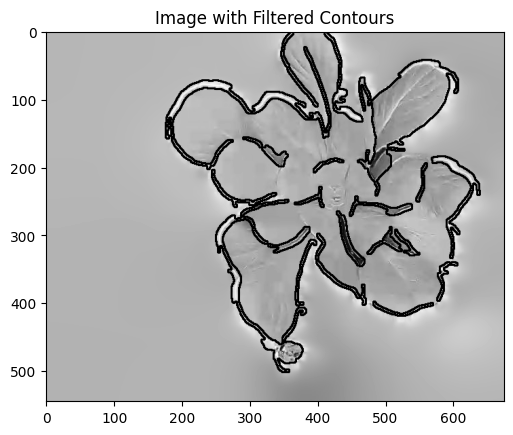

In [39]:
threshold_area = 2  # Adjust based on your image characteristics
aspect_ratio_min = 0.1
aspect_ratio_max = 5.0

# Filter contours based on size and shape
filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > threshold_area]
filtered_contours = [contour for contour in filtered_contours if aspect_ratio_min < cv2.boundingRect(contour)[2] / cv2.boundingRect(contour)[3] < aspect_ratio_max]

# Visualize the filtered contours
image_with_filtered_contours = image.copy()
cv2.drawContours(image_with_filtered_contours, filtered_contours, -1, (0, 255, 0), 2)
plt.imshow(image_with_filtered_contours, cmap='gray')
plt.title('Image with Filtered Contours')
plt.show()

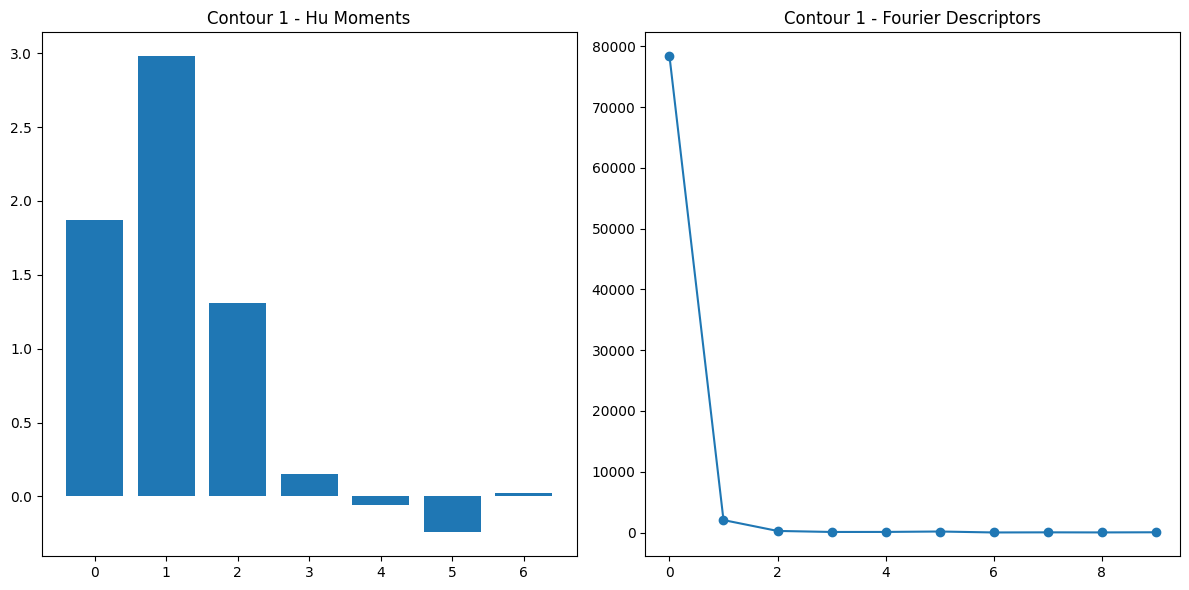

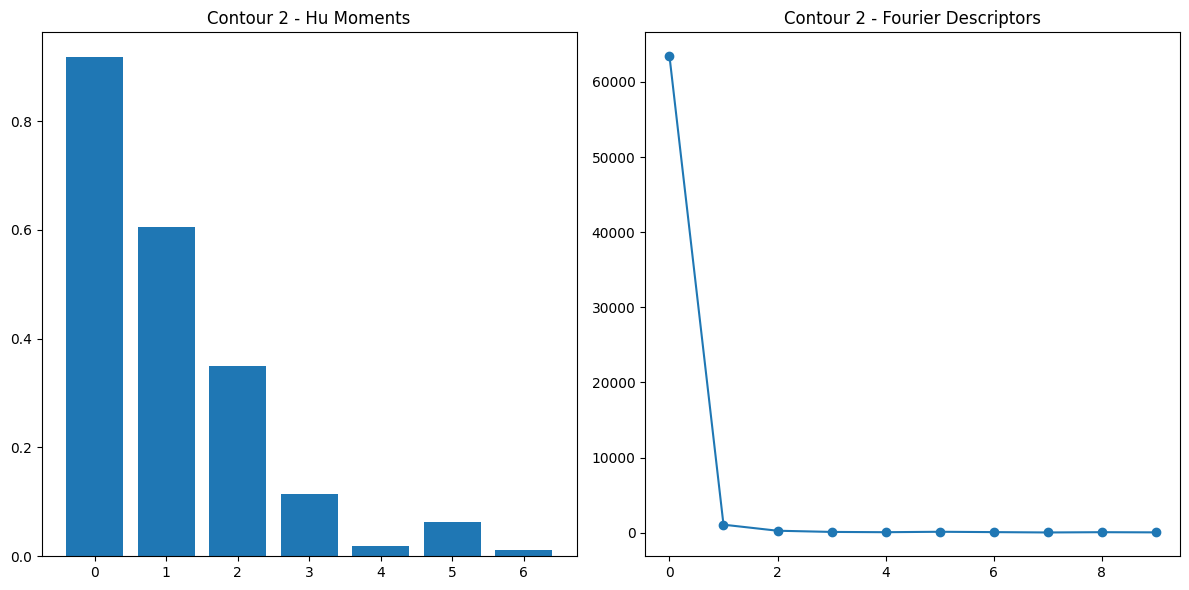

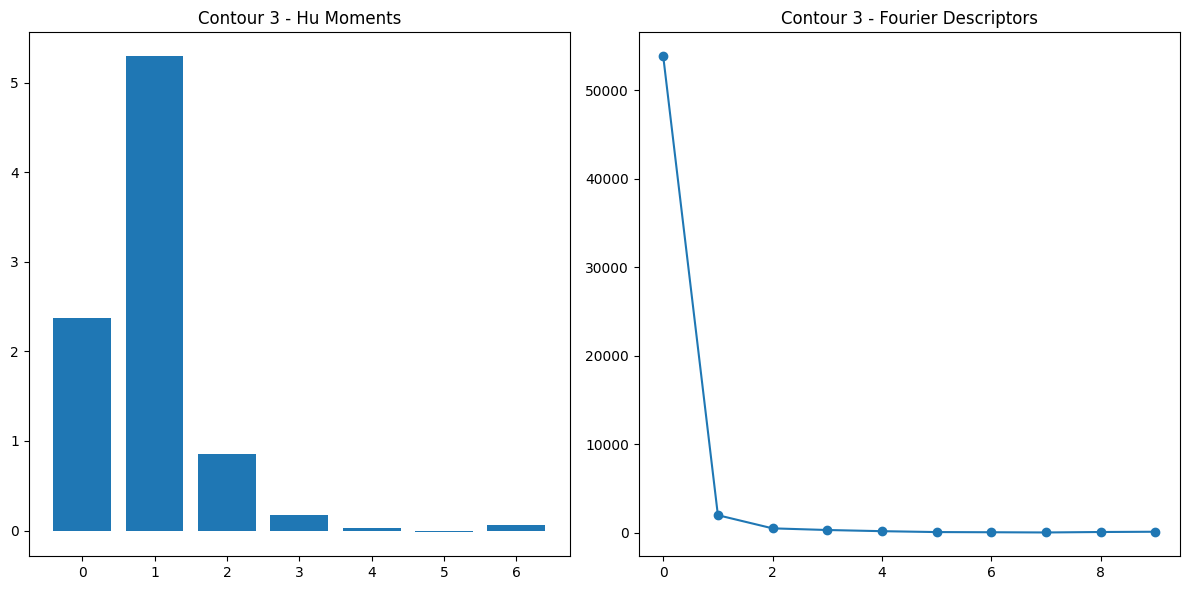

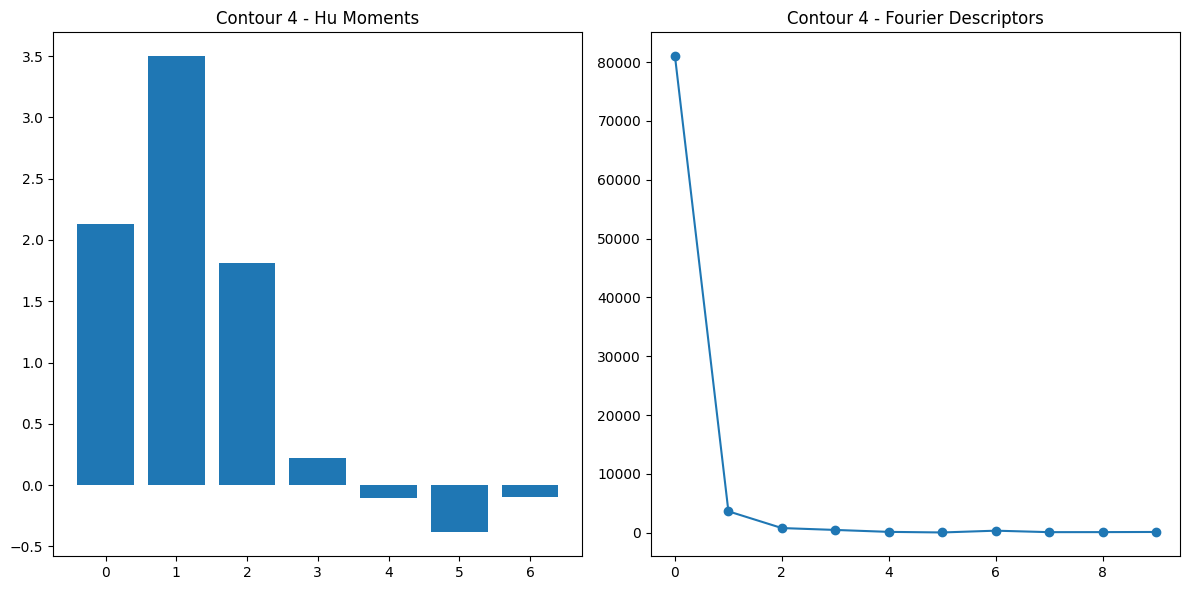

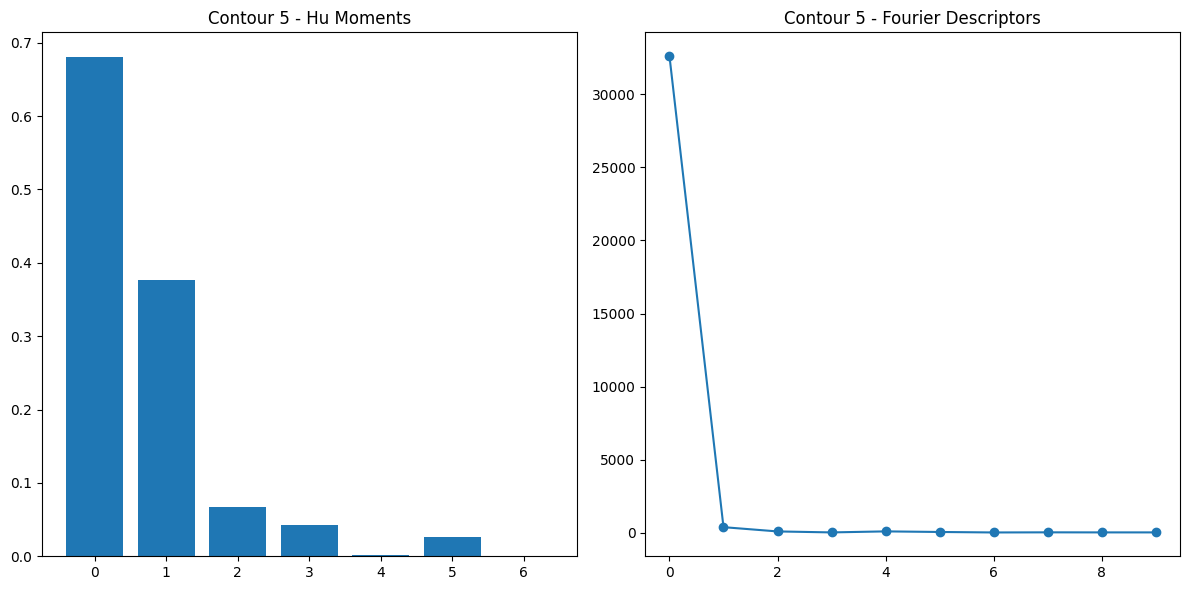

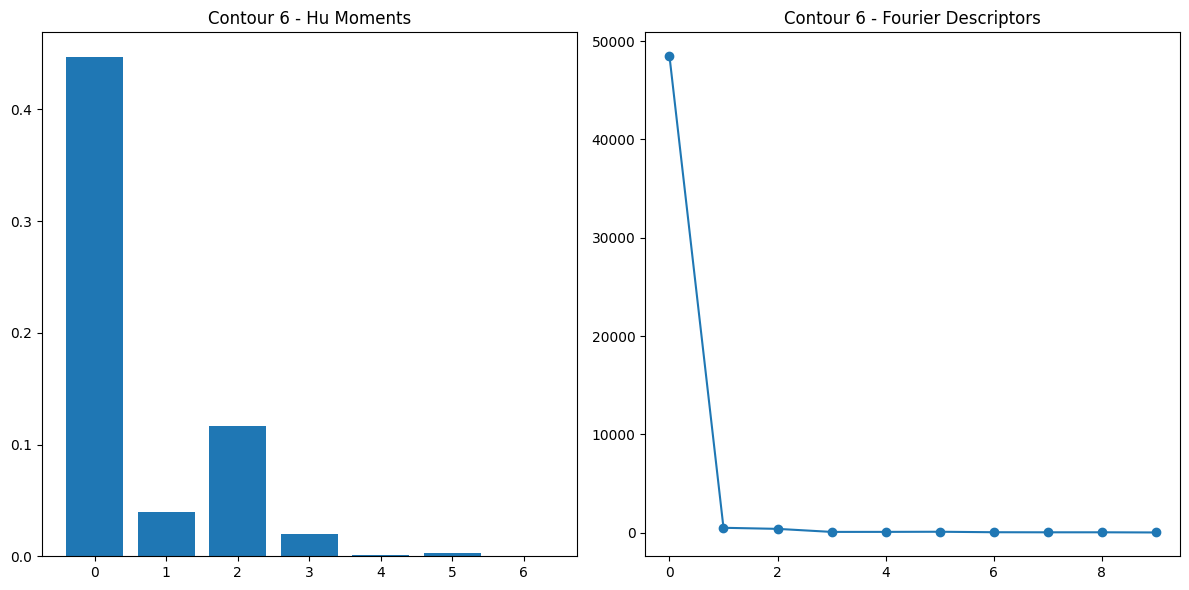

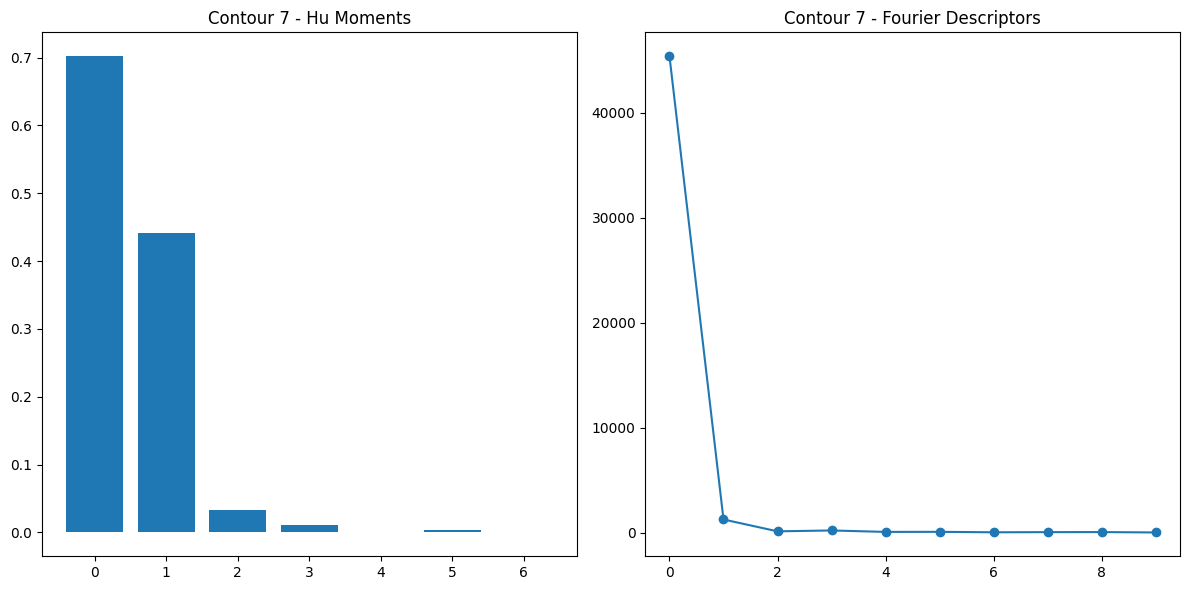

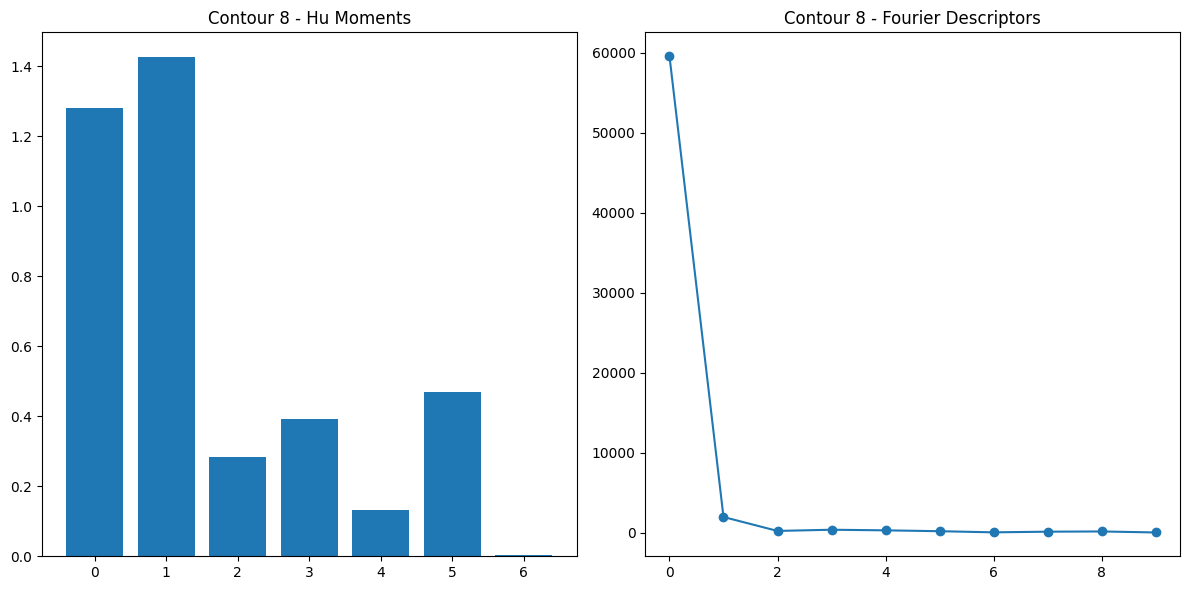

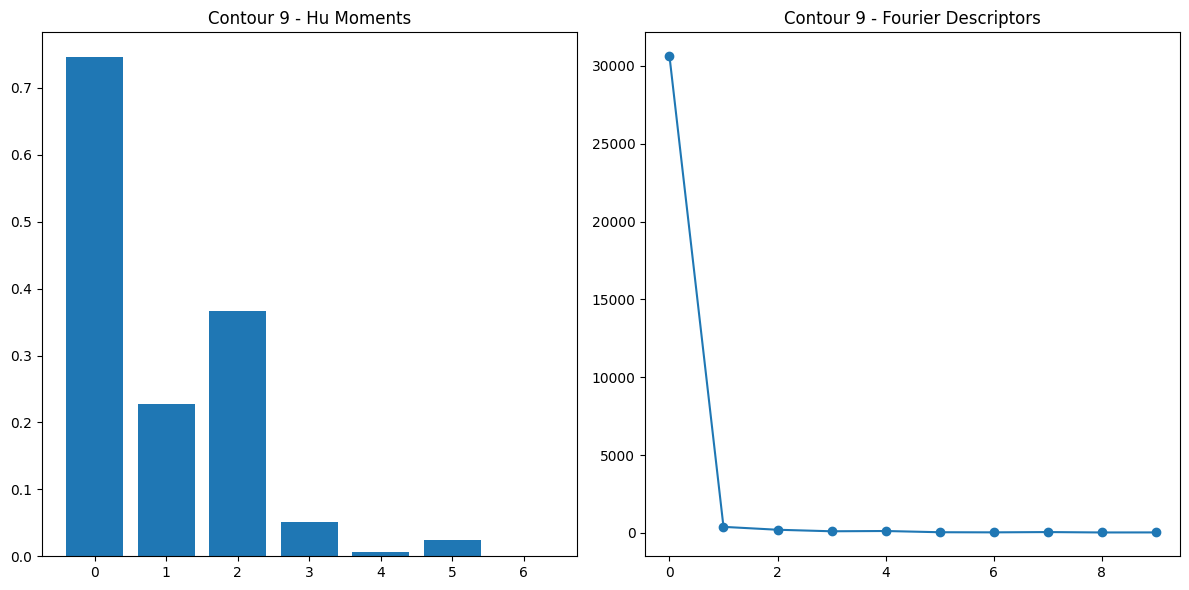

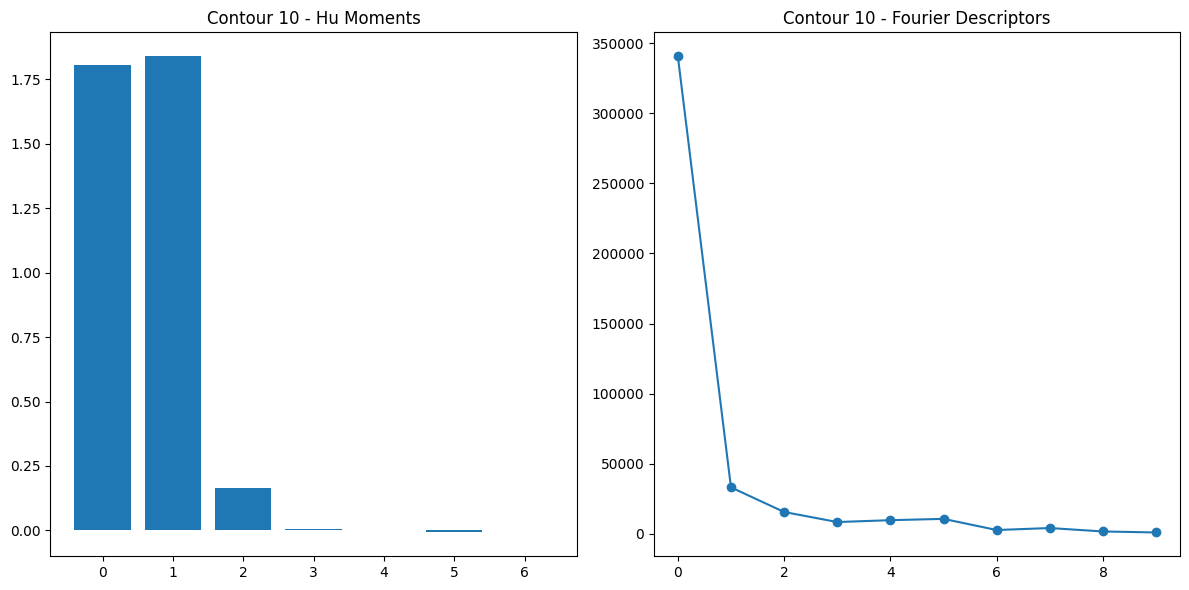

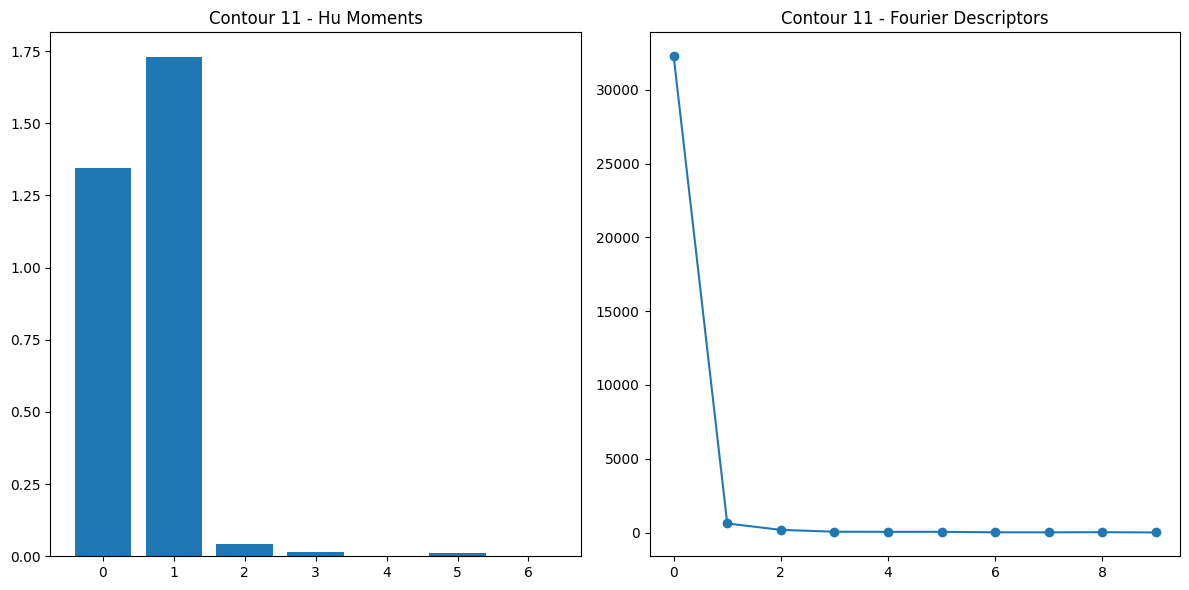

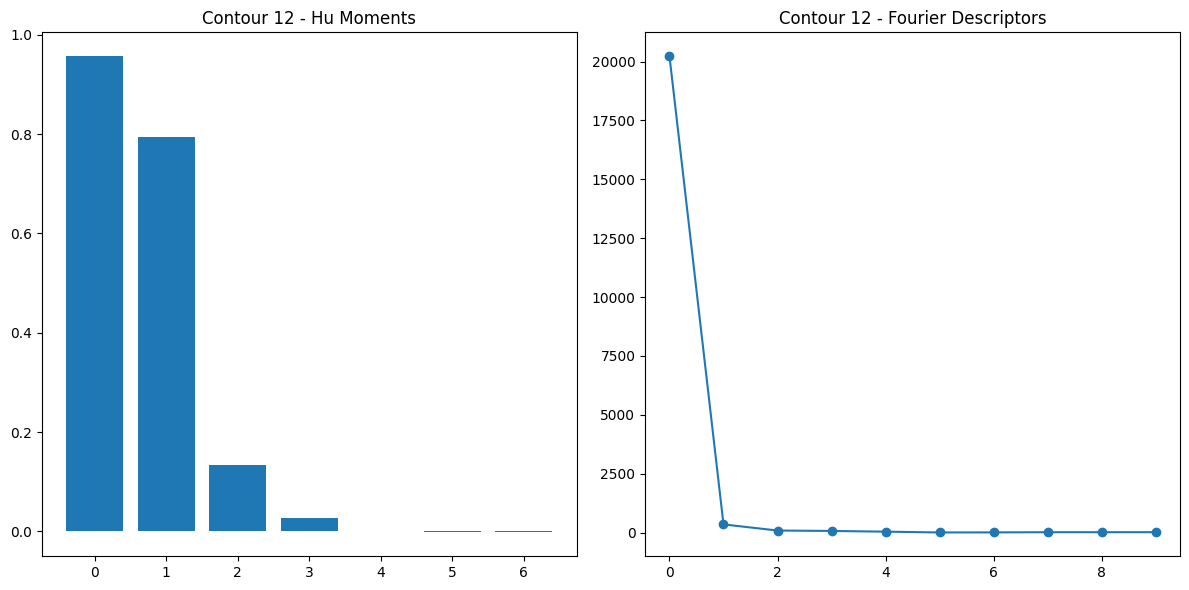

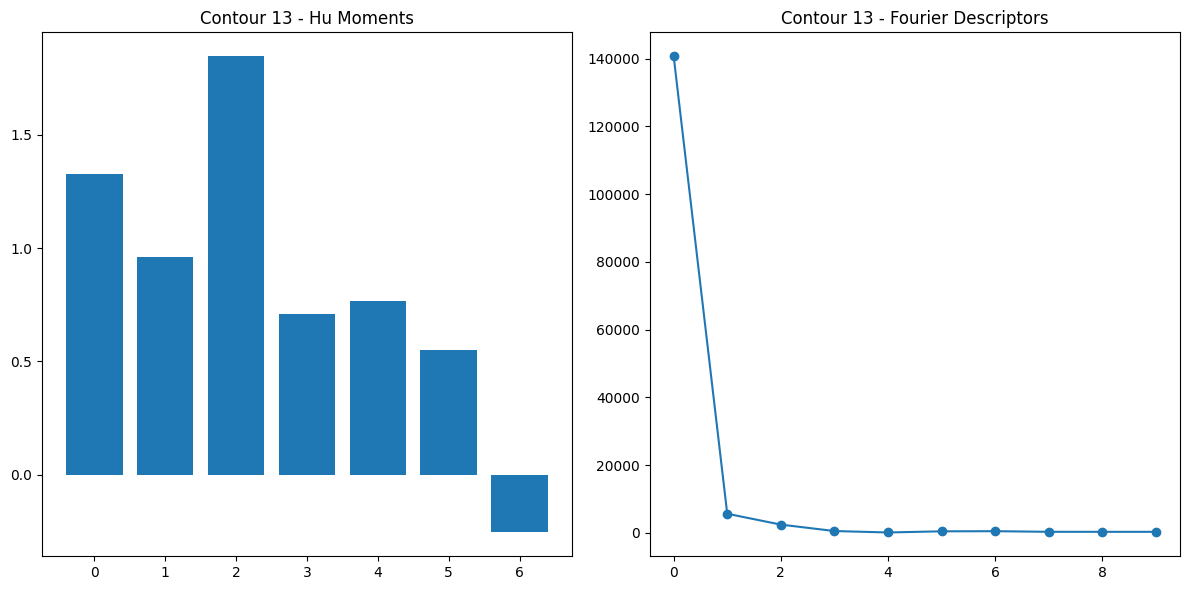

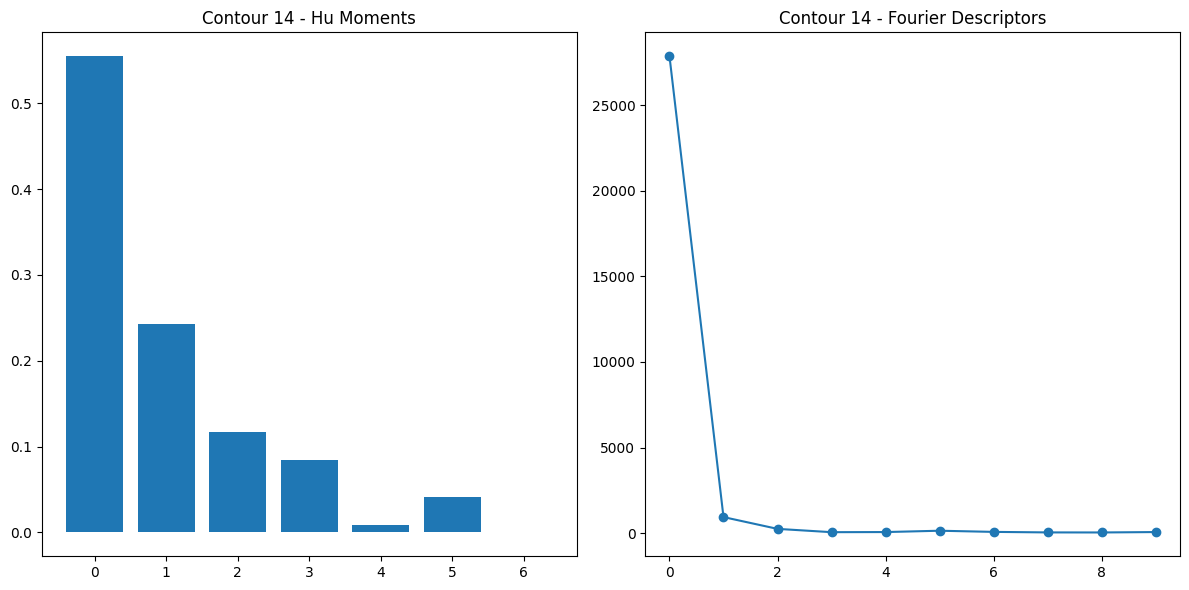

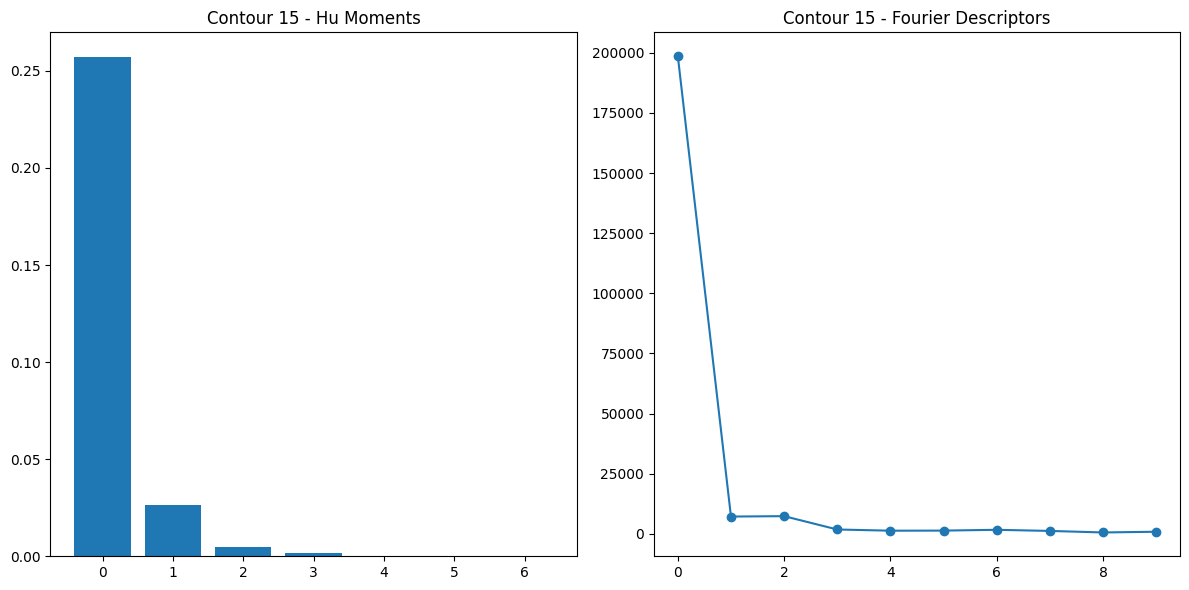

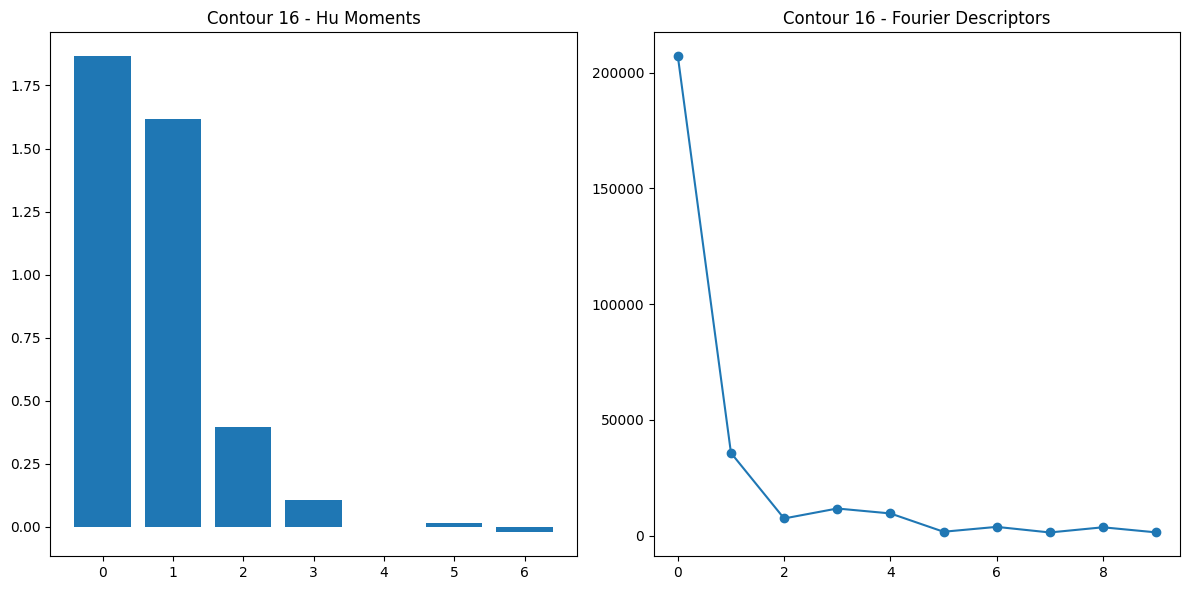

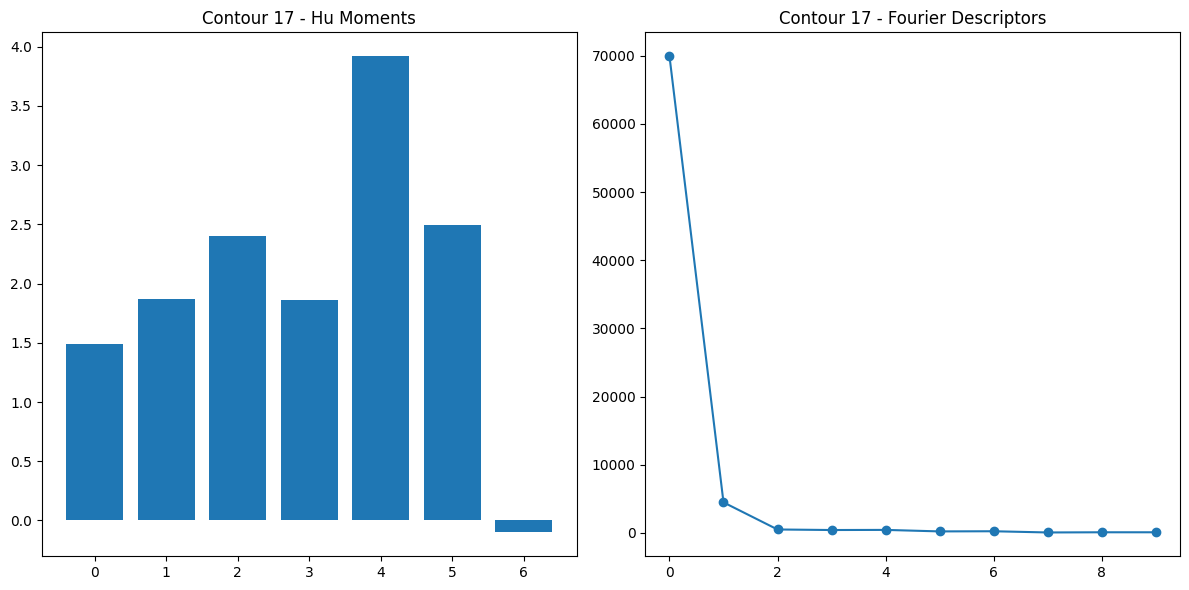

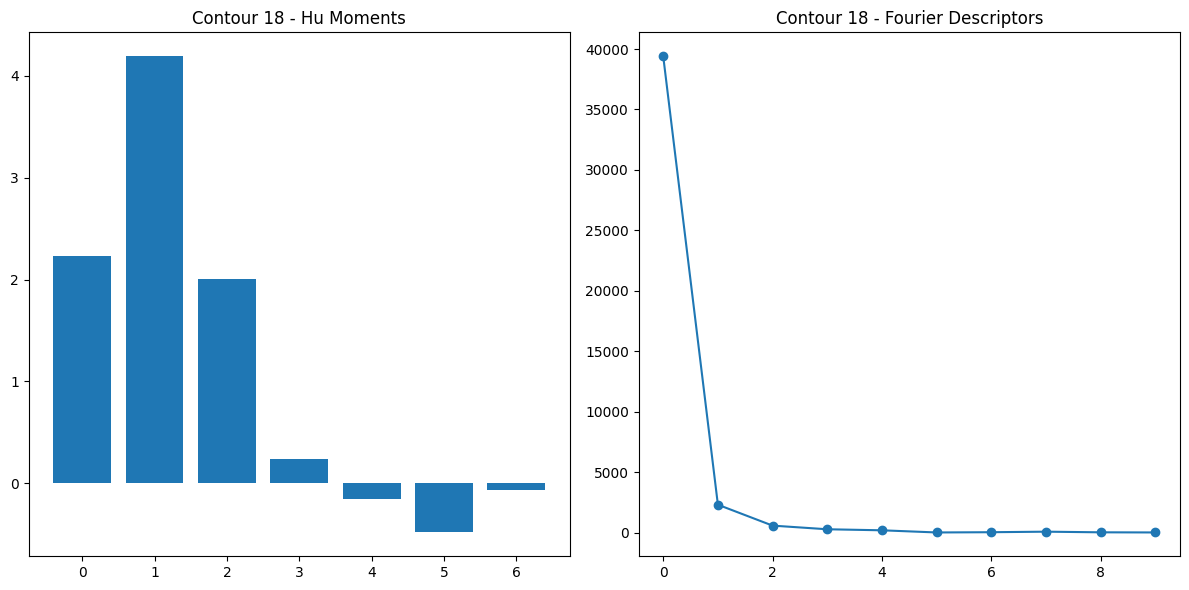

In [37]:
# Visualize results
for i in range(len(contours)):
    # Plot Hu Moments
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(7), hu_moments_list[i])
    plt.title(f'Contour {i + 1} - Hu Moments')

    # Plot Fourier Descriptors
    plt.subplot(1, 2, 2)
    plt.plot(fourier_descriptors_list[i], marker='o')
    plt.title(f'Contour {i + 1} - Fourier Descriptors')

    plt.tight_layout()
    plt.show()

#Distance Computation - connecting contours

From center lines are drawn to all the leaves's contour. Considering the fact that these lines may represent the no.of leaves.

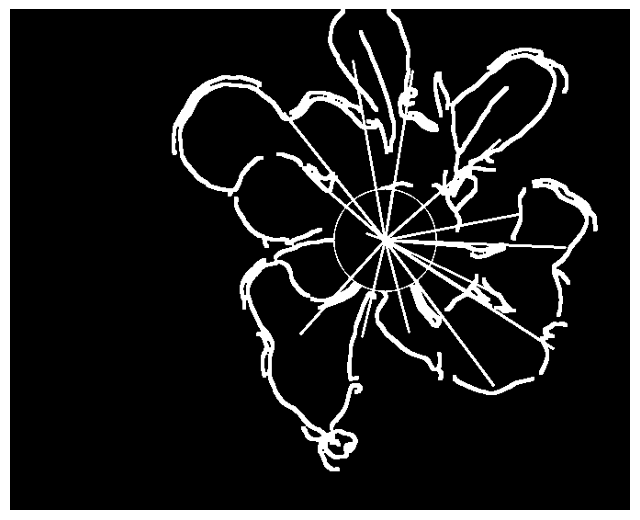

In [11]:
# Create a copy of the Canny edge image
connected_edges = edge_canny_tweaked_with_circle.copy()

# Step 13: Connect contours to the circle arc on the Canny edge image
for contour in contours:
    # Find the center of the bounding box
    x, y, w, h = cv2.boundingRect(contour)
    bbox_center = (x + w // 2, y + h // 2)

    # Draw a line connecting the contour center to the circle arc
    cv2.line(connected_edges, bbox_center, (plant_center_x, plant_center_y), (255, 255, 255), 2)

# Convert the connected edges image to RGB for Matplotlib
connected_rgb = cv2.cvtColor(connected_edges, cv2.COLOR_GRAY2RGB)

# Visualize the result using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(connected_rgb, cmap='gray')
plt.axis('off')
plt.show()

#Connected Components Identification + Leaf Labeling + Leaves Count

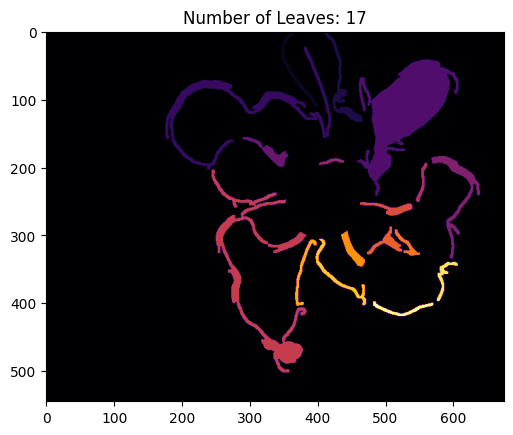

In [33]:
# Step 18: Create a binary mask for the connected leaves
leaves_mask = np.zeros_like(edge_canny_tweaked_with_circle)
cv2.drawContours(leaves_mask, contours, -1, 255, thickness=cv2.FILLED)

# Include the circular mask
leaves_mask[mask == 255] = 0

# Step 19: Find connected components in the leaves mask
_, labeled_leaves = cv2.connectedComponents(leaves_mask)

# Step 20: Count the number of leaves
num_leaves = np.max(labeled_leaves)

# Step 21: Visualize the labeled leaves
plt.imshow(labeled_leaves, cmap='inferno')
plt.title(f'Number of Leaves: {num_leaves}')
plt.show()

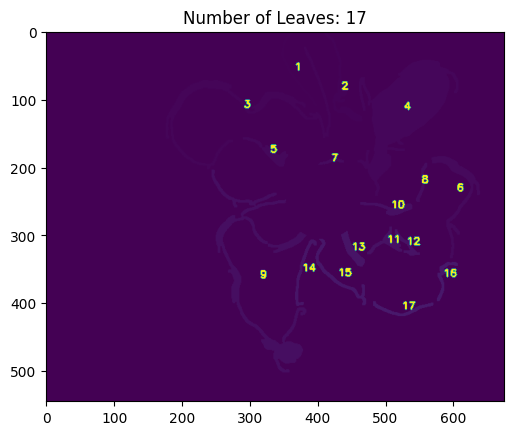

In [23]:
labeled_leaves_with_labels = labeled_leaves.copy()

leaf_counter = 0
for leaf_label in range(1, num_leaves + 1):
    # Find coordinates of the center of the leaf
    leaf_indices = np.where(labeled_leaves == leaf_label)
    if len(leaf_indices[0]) > 0:
        center_x = int(np.mean(leaf_indices[1]))
        center_y = int(np.mean(leaf_indices[0]))

        # Add sequential number label at the center
        leaf_counter += 1
        cv2.putText(labeled_leaves_with_labels, str(leaf_counter), (center_x, center_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255, 2)

# Step 23: Visualize the labeled leaves with sequential numbers
plt.imshow(labeled_leaves_with_labels, cmap='viridis')
plt.title(f'Number of Leaves: {leaf_counter}')
plt.show()

#Convex Hull on Enhanced Canny Image + Leaves Count

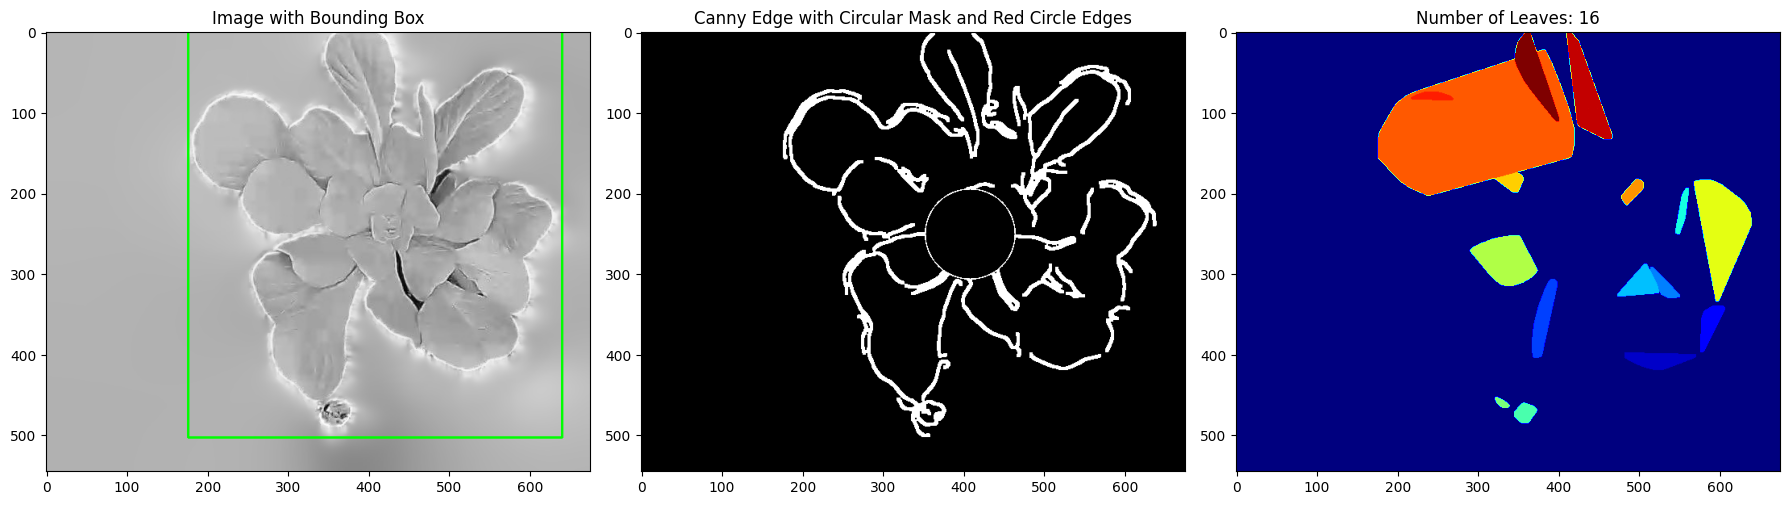

In [30]:
# Step 13: Contour Detection
contours, _ = cv2.findContours(edge_canny_tweaked_with_circle, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Step 14: Filtering Contours based on Size
filtered_contours = [cnt for cnt in contours if 100 < cv2.contourArea(cnt) < 5000]

# Step 15: Convex Hull
convex_hulls = [cv2.convexHull(cnt) for cnt in filtered_contours]

# Step 16: Leaf Feature Extraction
leaf_features = [{'area': cv2.contourArea(cnt), 'perimeter': cv2.arcLength(cnt, True)} for cnt in convex_hulls]

# Step 17: Leaf Labeling
labels = np.zeros_like(edge_canny_tweaked_with_circle)
for i, cnt in enumerate(convex_hulls):
    cv2.drawContours(labels, [cnt], -1, i + 1, thickness=cv2.FILLED)

# Step 18: Counting Leaves
num_leaves = len(leaf_features)

# Step 19: Visualize the results
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_with_bounding_box, cmap='gray')
plt.title('Image with Bounding Box')

plt.subplot(1, 3, 2)
plt.imshow(edge_canny_tweaked_with_circle, cmap='gray')
plt.title('Canny Edge with Circular Mask and Red Circle Edges')

plt.subplot(1, 3, 3)
plt.imshow(labels, cmap='jet')
plt.title(f'Number of Leaves: {num_leaves}')

plt.tight_layout()
plt.show()

#Draw Contours on Original Image

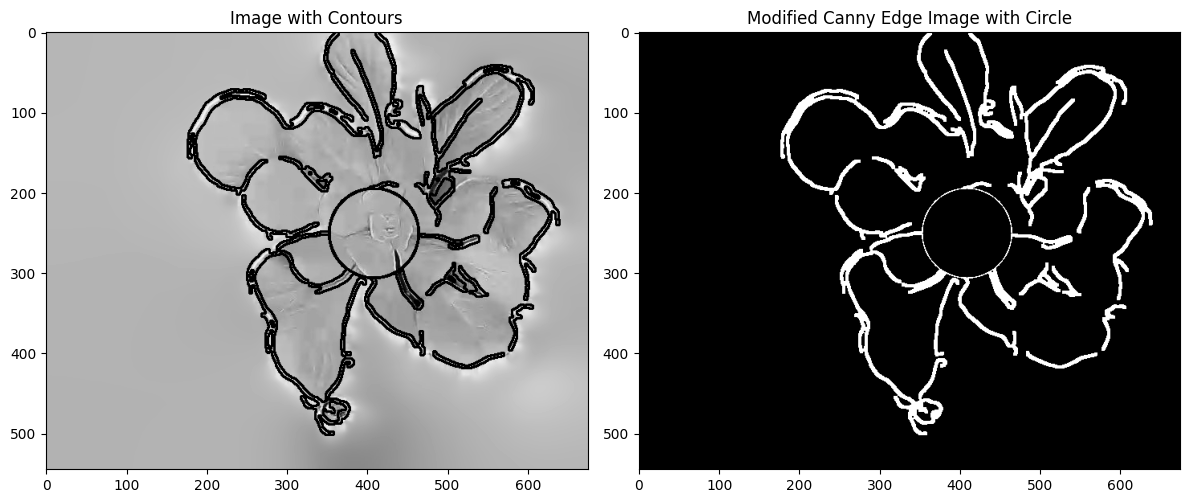

In [31]:
# Step 13: Contour Detection
contours, _ = cv2.findContours(edge_canny_tweaked_with_circle, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Step 14: Draw contours on the original image
image_with_contours = image.copy()
cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)

# Visualize the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_with_contours, cmap='gray')
plt.title('Image with Contours')

plt.subplot(1, 2, 2)
plt.imshow(edge_canny_tweaked_with_circle, cmap='gray')
plt.title('Modified Canny Edge Image with Circle')

plt.tight_layout()
plt.show()

#Connected Component using HSV Color Image

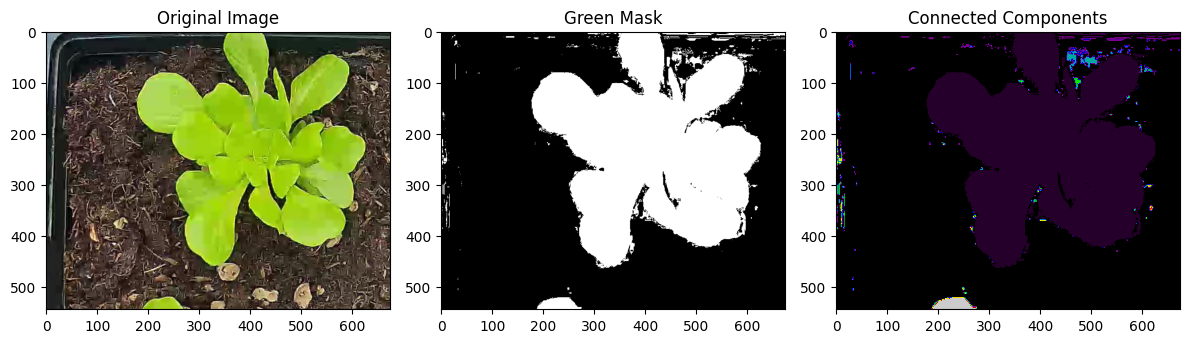

In [16]:
# Read the RGB image
image = cv2.imread('/content/drive/MyDrive/Balcony Cropped and Quadrants/plant1_01_06_2023_11_balcony.jpg')
# Convert the image to grayscale
# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the color range for the green plant
lower_green = np.array([30, 40, 40])
upper_green = np.array([90, 255, 255])

# Create a binary mask based on the color range
green_mask = cv2.inRange(hsv_image, lower_green, upper_green)

# Apply connected component analysis
_, labels = cv2.connectedComponents(green_mask)

# Convert the labels image to uint8 for visualization
labels_uint8 = np.uint8(labels)

# Visualize the labeled connected components
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(green_mask, cv2.COLOR_BGR2RGB))
plt.title('Green Mask')

plt.subplot(1, 3, 3)
plt.imshow(labels, cmap='nipy_spectral')  # You can use any colormap you prefer
plt.title('Connected Components')

plt.tight_layout()
plt.show()

#Leaves Skeleton Technique

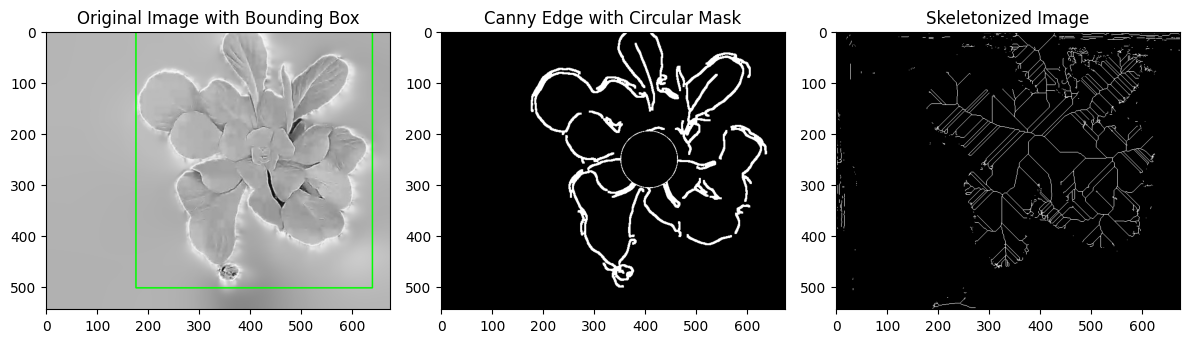

In [20]:
# Step 12: Perform Skeletonization

# Step 12: Binarize the image
binary_image = cv2.threshold(green_mask, 1, 1, cv2.THRESH_BINARY)[1]
skeleton = skeletonize(binary_image)

# Step 13: Visualize the original image with bounding box and the skeleton
plt.figure(figsize=(12, 6))

# Display the original image with bounding box
plt.subplot(1, 3, 1)
plt.imshow(image_with_bounding_box)
plt.title('Original Image with Bounding Box')

# Display the Canny edge image with circular mask
plt.subplot(1, 3, 2)
plt.imshow(edge_canny_tweaked_with_circle, cmap='gray')
plt.title('Canny Edge with Circular Mask')

# Display the skeletonized image
plt.subplot(1, 3, 3)
plt.imshow(skeleton, cmap='gray')
plt.title('Skeletonized Image')

plt.tight_layout()
plt.show()

#Feature Computation - Plant Area + Perimeter + Centroid

In [40]:
# Read the RGB image
image1 = cv2.imread('/content/drive/MyDrive/Balcony Cropped and Quadrants/plant1_01_06_2023_11_balcony.jpg')

# Convert the image to grayscale
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

# Apply thresholding to create a binary image
_, binary_image1 = cv2.threshold(gray_image1, 128, 255, cv2.THRESH_BINARY_INV)

# Find contours in the binary image
contours1, _ = cv2.findContours(binary_image1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize variables for plant parameters
plant_area = 0
plant_perimeter = 0
plant_centroid = (0, 0)

# Iterate through contours
for contour in contours:
    # Calculate area and perimeter of each contour
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    # Update plant parameters
    plant_area += area
    plant_perimeter += perimeter

    # Calculate the centroid of the contour
    M = cv2.moments(contour)
    if M["m00"] != 0:
        centroid_x = int(M["m10"] / M["m00"])
        centroid_y = int(M["m01"] / M["m00"])
        plant_centroid = (centroid_x, centroid_y)

# Display the plant parameters
print("Plant Area:", plant_area)
print("Plant Perimeter:", plant_perimeter)
print("Plant Centroid:", plant_centroid)

Plant Area: 29327.5
Plant Perimeter: 7620.320640325546
Plant Centroid: (366, 58)


#Watershed Segmentation

In [61]:
img = cv2.imread('/content/drive/MyDrive/Background_removed_lettuce/background_removed_lettuce/01/plant1_01_06_2023_15_balcony.jpg')
blur = cv2.GaussianBlur(img, (3, 3), 1)
h, w = img.shape[:2]

In [66]:
# Convert the image to HSV color space
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

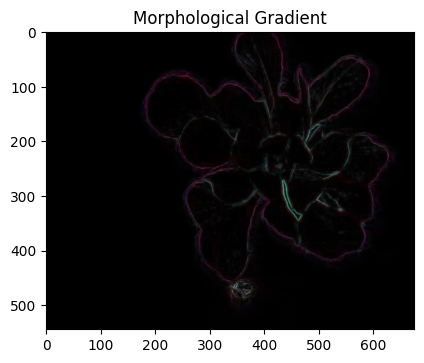

In [67]:
# Morphological gradient

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
gradient = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, kernel)

# Step 13: Visualize the original image with bounding box and the skeleton
plt.figure(figsize=(12, 6))

# Display the original image with bounding box
plt.subplot(1, 3, 1)
plt.imshow(gradient, cmap = 'gray')
plt.title('Morphological Gradient')

plt.tight_layout()
plt.show()

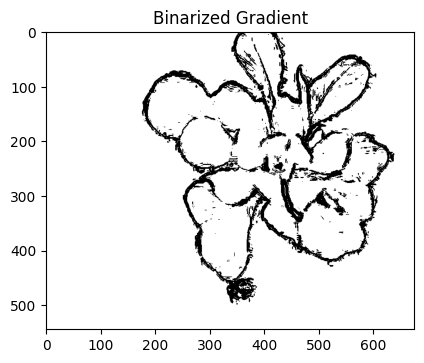

In [75]:
# Binarize gradient

lowerb = np.array([0, 0, 0])
upperb = np.array([15, 15, 15])

#lowerb = np.array([35, 40, 40])  # Adjust these values based on your specific case
#upperb = np.array([85, 255, 255])
binary = cv2.inRange(gradient, lowerb, upperb)

# Invert the binary image
#binary_inverted = cv2.bitwise_not(binary)

# Step 13: Visualize the original image with bounding box and the skeleton
plt.figure(figsize=(12, 6))

# Display the original image with bounding box
plt.subplot(1, 3, 1)
plt.imshow(binary, cmap = 'gray')
plt.title('Binarized Gradient')

plt.tight_layout()
plt.show()

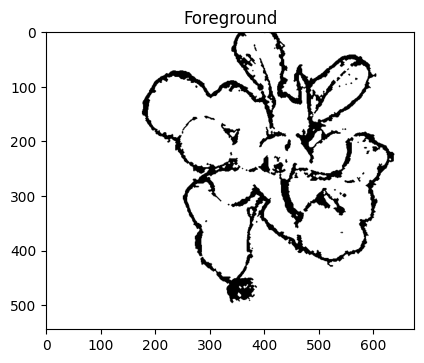

In [77]:
# Cleaning up mask

foreground = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
foreground = cv2.morphologyEx(foreground, cv2.MORPH_CLOSE, kernel)
# Step 13: Visualize the original image with bounding box and the skeleton
plt.figure(figsize=(12, 6))

# Display the original image with bounding box
plt.subplot(1, 3, 1)
plt.imshow(foreground, cmap = 'gray')
plt.title('Foreground')

plt.tight_layout()
plt.show()

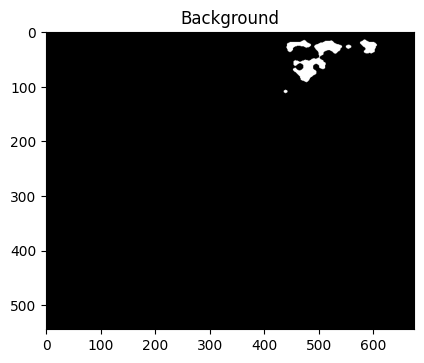

In [92]:
# Assuming foreground is your binary image (white plant on black background)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1))
background = cv2.erode(foreground, kernel, iterations=1)
unknown = cv2.subtract(background, foreground)

# Visualize the original image with bounding box and the skeleton
plt.figure(figsize=(12, 6))

# Display the original image with bounding box
plt.subplot(1, 3, 1)
plt.imshow(background, cmap='gray')
plt.title('Background')

plt.tight_layout()
plt.show()


In [81]:
# Watershed

markers = cv2.connectedComponents(foreground)[1]
markers += 1  # Add one to all labels so that background is 1, not 0
markers[unknown==255] = 0  # mark the region of unknown with zero
markers = cv2.watershed(img, markers)

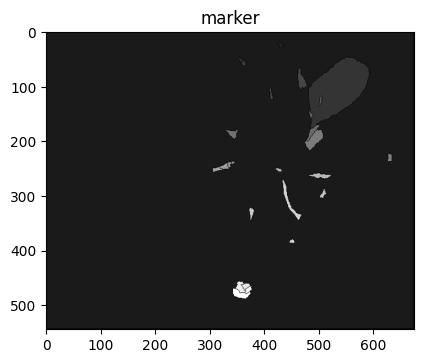

In [83]:
plt.figure(figsize=(12, 6))

# Display the original image with bounding box
plt.subplot(1, 3, 1)
plt.imshow(markers, cmap='gray')
plt.title('marker')

plt.tight_layout()
plt.show()

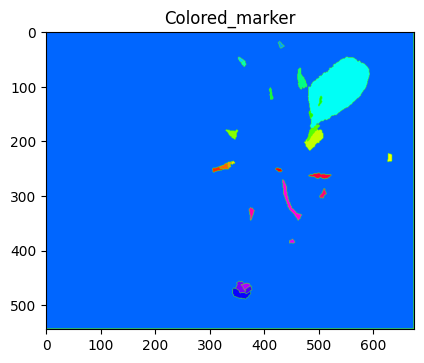

In [82]:
# Assign the markers a hue between 0 and 179

hue_markers = np.uint8(179*np.float32(markers)/np.max(markers))
blank_channel = 255*np.ones((h, w), dtype=np.uint8)
marker_img = cv2.merge([hue_markers, blank_channel, blank_channel])
marker_img = cv2.cvtColor(marker_img, cv2.COLOR_HSV2BGR)
plt.figure(figsize=(12, 6))

# Display the original image with bounding box
plt.subplot(1, 3, 1)
plt.imshow(marker_img, cmap='gray')
plt.title('Colored_marker')

plt.tight_layout()
plt.show()

#trying bounding box to identify ROI


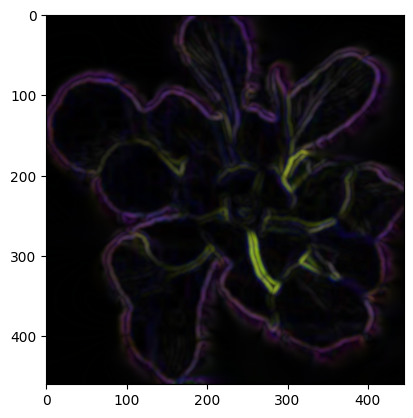

In [29]:
blur = cv2.GaussianBlur(cropped_region, (7, 7), 2)
h, w = cropped_region.shape[:2]

# Morphological gradient

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
gradient = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, kernel)
plt.imshow(gradient)

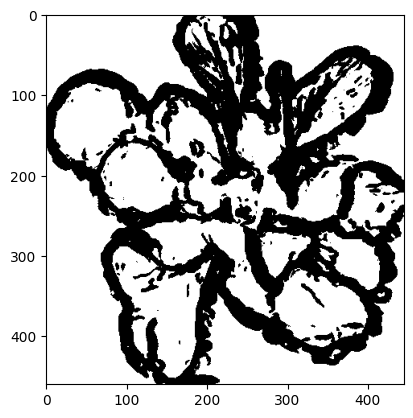

In [31]:
# Binarize gradient

lowerb = np.array([0, 0, 0])
upperb = np.array([15, 15, 15])
binary = cv2.inRange(gradient, lowerb, upperb)
plt.imshow(binary, cmap = 'gray')

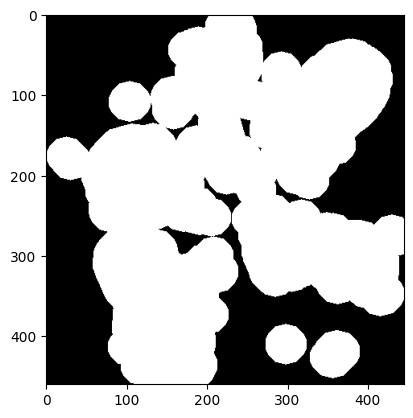

In [49]:
# Creating background and unknown mask for labeling

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 17))
background = cv2.dilate(binary, kernel, iterations=3)
unknown = cv2.subtract(background, foreground)
plt.imshow(background, cmap='gray')

In [56]:
# Watershed

markers = cv2.connectedComponents(binary)[1]
markers += 1  # Add one to all labels so that background is 1, not 0
markers[unknown==255] = 0  # mark the region of unknown with zero
markers = cv2.watershed(blur, markers)

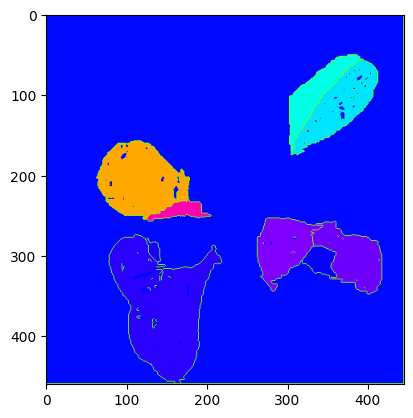

In [57]:
# Assign the markers a hue between 0 and 179

hue_markers = np.uint8(179*np.float32(markers)/np.max(markers))
blank_channel = 255*np.ones((h, w), dtype=np.uint8)
marker_img = cv2.merge([hue_markers, blank_channel, blank_channel])
marker_img = cv2.cvtColor(marker_img, cv2.COLOR_HSV2BGR)
plt.imshow( marker_img)

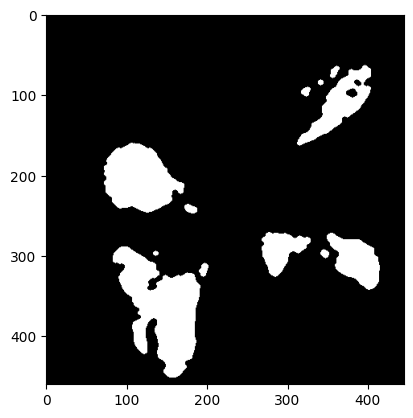

In [48]:
#foreground = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
#foreground = cv2.morphologyEx(foreground, cv2.MORPH_CLOSE, kernel)
#plt.imshow(foreground, cmap='gray')

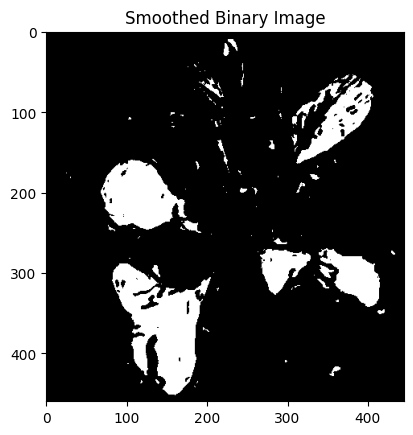

In [43]:
# Apply dilation to the binary image
kernel_dilation = np.ones((1,1), np.uint8)
binary_smoothed = cv2.dilate(binary, kernel_dilation, iterations=1)

# Visualize the smoothed binary image
plt.imshow(binary_smoothed, cmap='gray')
plt.title('Smoothed Binary Image')
plt.show()

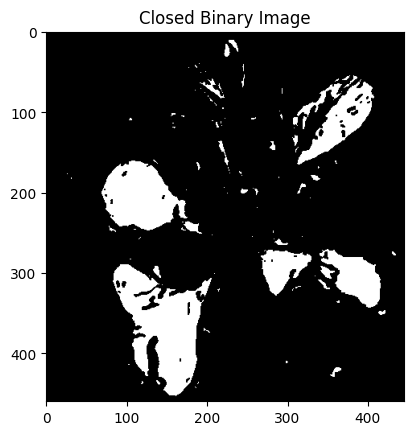

In [45]:
# Apply closing to the binary image with a suitable kernel
kernel_closing = np.ones((2, 2), np.uint8)
binary_closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_closing)

# Visualize the closed binary image
plt.imshow(binary_closed, cmap='gray')
plt.title('Closed Binary Image')
plt.show()

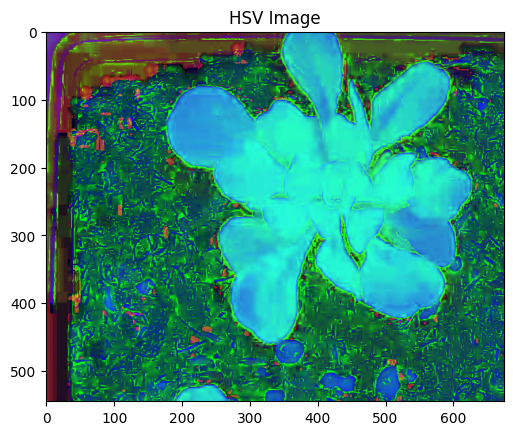

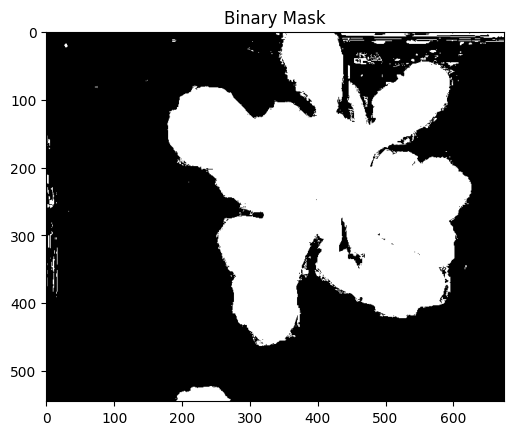

In [88]:
# Convert the image to HSV color space
hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Debug: Visualize the HSV image
plt.imshow(hsv_image)
plt.title('HSV Image')
plt.show()

# Define the color range for the green plant
lower_green = np.array([35, 40, 40])  # Adjust these values based on your specific case
upper_green = np.array([85, 255, 255])

# Create a binary mask based on the color range
green_mask = cv2.inRange(hsv_image, lower_green, upper_green)

# Debug: Visualize the binary mask
plt.imshow(green_mask, cmap='gray')
plt.title('Binary Mask')
plt.show()

#HSV Color Space + Watershed Segmentation

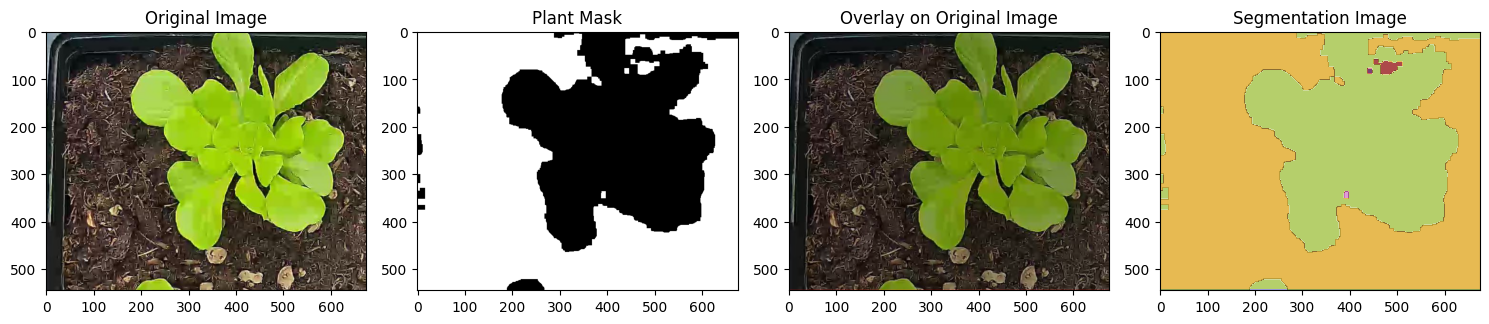

In [104]:
# Load the image
image = cv2.imread('/content/drive/MyDrive/Balcony Cropped and Quadrants/plant1_01_06_2023_11_balcony.jpg')
# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the color range for the green plant
lower_green = np.array([30, 40, 40])
upper_green = np.array([90, 255, 255])

# Create a binary mask based on the color range
green_mask = cv2.inRange(hsv, lower_green, upper_green)

# Invert the mask to get the plant in white and background in black
plant_mask = cv2.bitwise_not(green_mask)

# Use morphological operations to clean up the mask
kernel = np.ones((5, 5), np.uint8)
plant_mask = cv2.morphologyEx(plant_mask, cv2.MORPH_OPEN, kernel, iterations=2)
plant_mask = cv2.morphologyEx(plant_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

# Label markers for watershed algorithm
_, markers = cv2.connectedComponents(plant_mask)
markers += 1

# Apply watershed algorithm
markers = cv2.watershed(image, markers)

# Create a mask to overlay the segmented regions
segmentation_mask = np.zeros_like(image)
segmentation_mask[markers == -1] = [0, 0, 255]  # Mark watershed boundaries in red

# Visualize the results
plt.figure(figsize=(15, 6))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(plant_mask, cmap='gray')
plt.title('Plant Mask')

plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(cv2.addWeighted(image, 0.7, segmentation_mask, 0.3, 0), cv2.COLOR_BGR2RGB))
plt.title('Overlay on Original Image')

plt.subplot(1, 4, 4)
plt.imshow(markers, cmap='tab20b')
plt.title('Segmentation Image')

plt.tight_layout()
plt.show()

#LAB Color Space + K-means

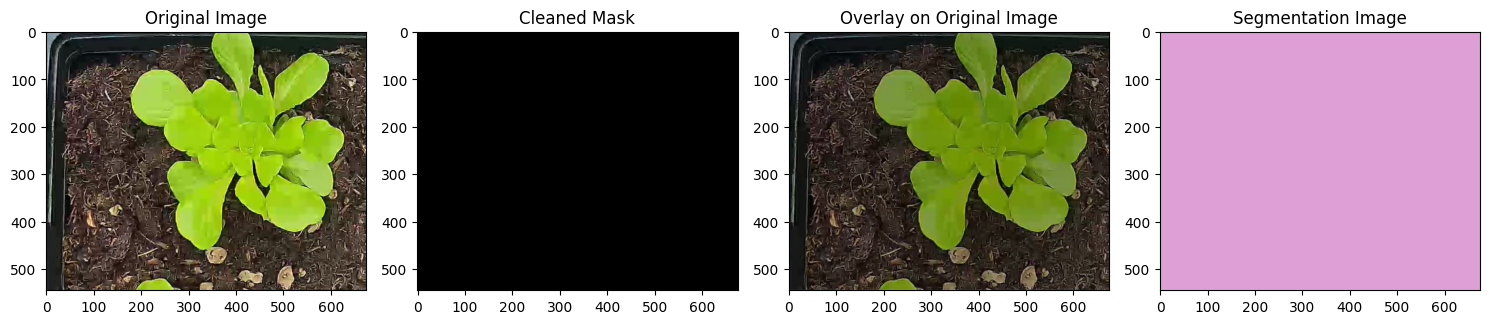

In [107]:
# Convert the image to the LAB color space
lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# Apply k-means clustering to reduce the number of colors
k = 3  # You can adjust this based on your needs
reshaped_image = lab.reshape((-1, 3))
reshaped_image = np.float32(reshaped_image)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(reshaped_image, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image.shape)

# Convert the segmented image to grayscale
gray_segmented = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding to create a mask
_, thresholded_mask = cv2.threshold(gray_segmented, 1, 255, cv2.THRESH_BINARY)

# Use morphological operations to clean up the mask
kernel = np.ones((5, 5), np.uint8)
cleaned_mask = cv2.morphologyEx(thresholded_mask, cv2.MORPH_OPEN, kernel, iterations=2)
cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

# Find contours in the cleaned mask
contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create an empty mask for markers
markers = np.zeros_like(cleaned_mask, dtype=np.int32)

# Assign different markers for each leaf
marker_count = 1
for i, contour in enumerate(contours):
    cv2.drawContours(markers, [contour], 0, (marker_count,), -1)
    marker_count += 1

# Apply watershed algorithm
cv2.watershed(image, markers)

# Create a mask to overlay the segmented regions
segmentation_mask = np.zeros_like(image)
segmentation_mask[markers == -1] = [0, 0, 255]  # Mark watershed boundaries in red

# Visualize the results
plt.figure(figsize=(15, 6))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(cleaned_mask, cmap='gray')
plt.title('Cleaned Mask')

plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(cv2.addWeighted(image, 0.7, segmentation_mask, 0.3, 0), cv2.COLOR_BGR2RGB))
plt.title('Overlay on Original Image')

plt.subplot(1, 4, 4)
plt.imshow(markers, cmap='tab20b')
plt.title('Segmentation Image')

plt.tight_layout()
plt.show()